## Import Libraries

In [106]:
#-------- data manipulation --------
import pandas as pd
import sqlite3
import numpy as np

#------- time manipulation ---------
import time

#------ finance indicators ---------
import ta

#---------- visualization ----------
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go

#-------- basic statistics ---------
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from statsmodels.stats.diagnostic import normal_ad

#----- time series analysis --------
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

#------ os manipulation -----------
import os

## Function to read data from SQLite

In [74]:
def load_ohlcv_from_sqlite(table_name: str, db_path: str, start: str = None, end: str = None) -> pd.DataFrame:
    """
    Loads OHLCV data from a SQLite database table for backtesting.

    Parameters:
    - table_name: str, name of the table (e.g., 'btc_1h')
    - db_path: str, path to the SQLite database
    - start: str (optional), start timestamp in 'YYYY-MM-DD' or 'YYYY-MM-DD HH:MM:SS'
    - end: str (optional), end timestamp in 'YYYY-MM-DD' or 'YYYY-MM-DD HH:MM:SS'

    Returns:
    - DataFrame with datetime index and OHLCV columns
    """
    query = f"SELECT * FROM {table_name}"
    if start and end:
        query += f" WHERE timestamp BETWEEN '{start}' AND '{end}'"
    elif start:
        query += f" WHERE timestamp >= '{start}'"
    elif end:
        query += f" WHERE timestamp <= '{end}'"

    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql(query, conn, parse_dates=["timestamp"])
    
    df.set_index("timestamp", inplace=True)
    df = df.sort_index()
    return df

# Example usage (commented, to be used interactively):
# btc_df = load_ohlcv_from_sqlite("btc_1h", "/mnt/data/crypto_data.sqlite", start="2024-01-01", end="2025-01-01")


## 1. Get data

In [75]:
db_path = "data/crypto_data.sqlite"

In [76]:
btc = load_ohlcv_from_sqlite(
    table_name="btc_1h", 
    db_path=db_path, 
    start="2022-12-30", 
    end="2025-06-29"
)

In [77]:
btc

open       high        low      close  \
timestamp                                                               
2022-12-31 18:00:00-06:00   16541.77   16545.70   16508.39   16529.67   
2022-12-31 19:00:00-06:00   16529.59   16556.80   16525.78   16551.47   
2022-12-31 20:00:00-06:00   16551.47   16559.77   16538.14   16548.19   
2022-12-31 21:00:00-06:00   16548.19   16548.19   16518.21   16533.04   
2022-12-31 22:00:00-06:00   16533.04   16535.97   16511.92   16521.85   
...                              ...        ...        ...        ...   
2025-06-28 14:00:00-06:00  107225.74  107235.40  107154.62  107169.52   
2025-06-28 15:00:00-06:00  107169.52  107347.65  107169.52  107331.38   
2025-06-28 16:00:00-06:00  107331.37  107378.37  107257.09  107370.61   
2025-06-28 17:00:00-06:00  107370.61  107370.62  107282.72  107296.79   
2025-06-28 18:00:00-06:00  107296.79  107500.00  107254.16  107475.92   

                               volume  
timestamp                              
2022-12-31 18:00:00-06:00  4364.83570  
2022-12-31 19:00:00-06:00  3590.06669  
2022-12-31 20:00:00-06:00  3318.84038  
2022-12-31 21:00:00-06:00  4242.08050  
2022-12-31 22:00:00-06:00  4285.00909  
...                               ...  
2025-06-28 14:00:00-06:00    80.40679  
2025-06-28 15:00:00-06:00    82.17435  
2025-06-28 16:00:00-06:00   141.59714  
2025-06-28 17:00:00-06:00    75.06468  
2025-06-28 18:00:00-06:00   216.23676  

[21840 rows x 5 columns]

### 1.1 Calculate Log Returns

In [78]:
btc["returns"] = btc.close / btc.close.shift(periods=1)
btc["log_ret"] = np.log(btc.returns)

In [79]:
btc.head()

open      high       low     close      volume  \
timestamp                                                                       
2022-12-31 18:00:00-06:00  16541.77  16545.70  16508.39  16529.67  4364.83570   
2022-12-31 19:00:00-06:00  16529.59  16556.80  16525.78  16551.47  3590.06669   
2022-12-31 20:00:00-06:00  16551.47  16559.77  16538.14  16548.19  3318.84038   
2022-12-31 21:00:00-06:00  16548.19  16548.19  16518.21  16533.04  4242.08050   
2022-12-31 22:00:00-06:00  16533.04  16535.97  16511.92  16521.85  4285.00909   

                            returns   log_ret  
timestamp                                      
2022-12-31 18:00:00-06:00       NaN       NaN  
2022-12-31 19:00:00-06:00  1.001319  0.001318  
2022-12-31 20:00:00-06:00  0.999802 -0.000198  
2022-12-31 21:00:00-06:00  0.999084 -0.000916  
2022-12-31 22:00:00-06:00  0.999323 -0.000677

## 2. Iterative function

In [80]:
def simulate_market(df, delay=0.5):
    """
    Simulate real-time market by yielding one row at a time.
    """
    for i in range(1, len(df)):
        yield df.iloc[:i+1]  # progressively reveal one more row
        time.sleep(delay)

## 3. Base function for backtesting

This includes z-score stratrgy as reference

In [70]:
# ---------------- SET-UP ----------------
ts_x, close_y, logret_y       = [], [], []
cstrategy_y, creturns_y       = [], []     # <-- will be filled now
meanret_y, position_y         = [], []     # (optional: to inspect position)

results_log = []
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

# -------------- MAIN LOOP --------------
for n, data in enumerate(simulate_market(btc, delay=0.05), start=1):
    latest   = data.iloc[-1]
    tstamp   = latest.name

    prev_pos = position        # use yesterday’s stance for today’s P/L

    # ---------- RETURN ACCRUAL ----------
    cum_asset += latest.log_ret
    cum_strat += prev_pos * latest.log_ret

    creturns_y.append(np.exp(cum_asset))      # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))     # strategy equity curve

    # ---------- STATISTICS BLOCK (unchanged logic) ----------
    skewness_val = kurtosis_val = ad = p_value = np.nan
    mean_ret     = std_ret = last_z_score = np.nan
    sample       = None

    if len(data) >= 50:
        train = data['log_ret'].dropna().iloc[-50:]
        sample = train.copy()

        skewness_val = skew(train)
        kurtosis_val = kurtosis(train, fisher=False)
        ad, p_value  = normal_ad(train)

        mean_ret = train.mean()
        std_ret  = train.std()

        if (std_ret > 0) and (p_value >= 0.05):
            last_z_score = (train.iloc[-1] - mean_ret) / std_ret

            # -------- UPDATE POSITION ONLY IF ±2σ BREACHED --------
            if   last_z_score >  2:
                position = 0          # flat / wait
            elif last_z_score < -2:
                position = 1          # long / buy
            # else: keep previous position
    # --------------------------------------------------------------

    # ---------- LOGGING ARRAYS ----------
    ts_x.append(tstamp)
    close_y.append(latest.close)
    logret_y.append(latest.log_ret)
    meanret_y.append(mean_ret)
    position_y.append(position)

    results_log.append(dict(
        timestamp     = tstamp,
        close         = latest.close,
        log_ret       = latest.log_ret,
        mean_ret      = mean_ret,
        kurtosis_val  = kurtosis_val,
        skewness_val  = skewness_val,
        ad            = ad,
        p_value       = p_value,
        z             = last_z_score,
        position      = position,
        creturns      = creturns_y[-1],      # buy-&-hold equity curve
        cstrategy     = cstrategy_y[-1]      # z-score strategy curve
    ))

    # ------------------ PLOTTING ------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])

    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.set_title("BTC Close Price"); ax1.grid(True)

    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="Z-Score Strategy", color="green", alpha=0.5)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.plot(ts_x, meanret_y, color="red", ls="--", label="mean_ret")
    ax3.set_title("Log Returns (50-bar window)"); ax3.legend(); ax3.grid(True)

    # 4A) Histogram
    if sample is not None:
        ax4 = fig.add_subplot(gs[2, 0])
        sns.histplot(sample, kde=True, ax=ax4, stat="density",
                     color="steelblue", label="hist+KDE")
        ax4.set_title(f"Hist  Skew={skewness_val:.2f}  Kurt={kurtosis_val:.2f}\n"
                      f"p={p_value:.4f}")
        ax4.legend()

        # 4B) Q-Q plot
        ax5 = fig.add_subplot(gs[2, 1])
        stats.probplot(sample, dist="norm", plot=ax5)
        ax5.set_title("Q-Q Plot"); ax5.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close: {latest.close:,.2f} | "
          f"log_ret: {latest.log_ret: .5f} | z: {last_z_score: .2f} | "
          f"pos: {position}")

    if n == 100:
        break

# -------------- FINAL DF --------------
df_results = (pd.DataFrame(results_log)
              .set_index("timestamp")
              .sort_index())


KeyboardInterrupt: 

## 4 Strategies

### 4.1 Analysis of log returns using Bollinger Bands

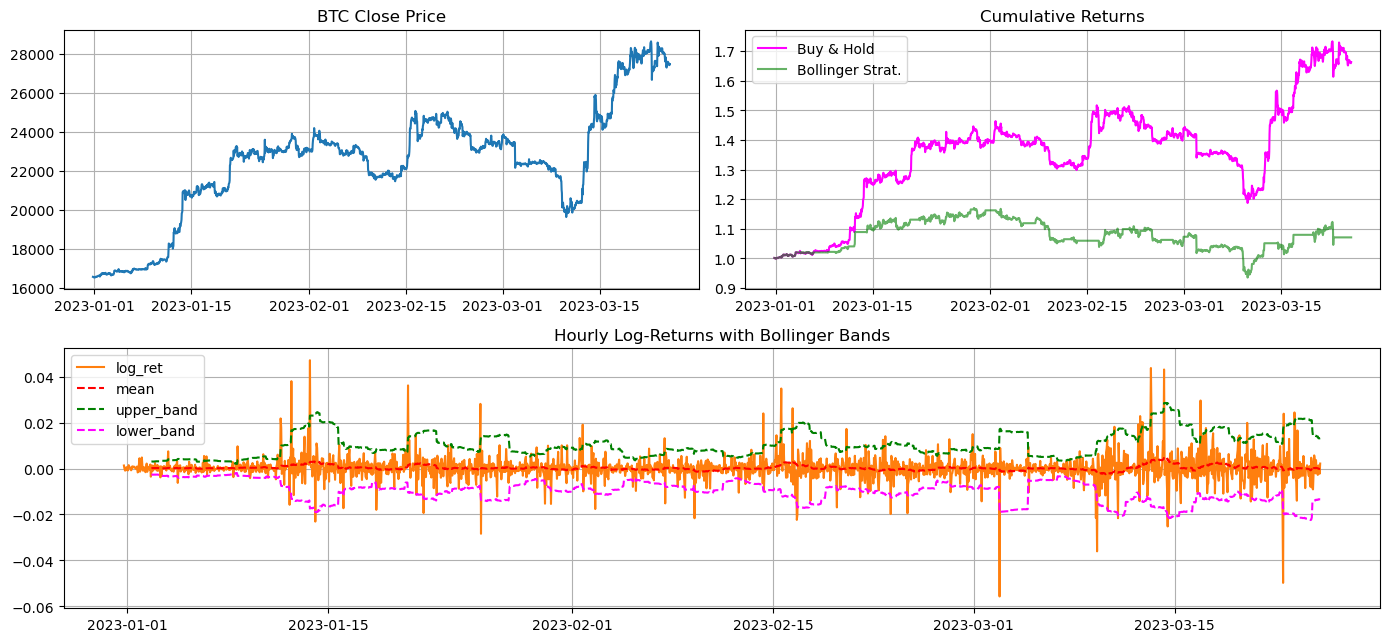

2000 | 2023-03-25 03:00:00-06:00 | Close: 27,481.96 | log_ret:  0.00216 | pos: 0


In [ ]:
# ---------------- SET-UP ----------------
ts_x, close_y, logret_y = [], [], []
cstrategy_y, creturns_y = [], []
meanret_y, position_y   = [], []
upperb_y, lowerb_y      = [], []

results_log = []

position  = 1                 # 1 = long ; 0 = flat
cum_asset = 0.0               # cumulative *log* return of BTC
cum_strat = 0.0               # cumulative *log* return of strategy

window = 48     # Bollinger look-back (2 trading day)
k      = 2      # ±k·σ bands

# -------------- MAIN LOOP --------------
for n, data in enumerate(simulate_market(btc, delay=0.05), start=1):
    latest  = data.iloc[-1]
    tstamp  = latest.name
    ret     = latest.log_ret          # for brevity

    # --- P/L accrual with *yesterday’s* stance ---
    cum_asset += ret
    cum_strat += position * ret       # position from previous bar

    creturns_y.append(np.exp(cum_asset))
    cstrategy_y.append(np.exp(cum_strat))

    # ------------ BOLLINGER BLOCK -------------
    if len(data) >= window:
        roll = data['log_ret'].dropna().iloc[-window:]
        mean_ret  = roll.mean()
        std_ret   = roll.std()

        upper_band = mean_ret + k * std_ret
        lower_band = mean_ret - k * std_ret

        # --- trade signal: update *after* booking P/L ---
        if   ret < lower_band:
            position = 1            # long / oversold
        elif ret > upper_band:
            position = 0            # flat / overbought
        # else: keep previous position
    else:
        # not enough data yet → NaNs keep plots aligned
        mean_ret  = upper_band = lower_band = np.nan

    # ------------- LOGGING ARRAYS -------------
    ts_x.append(tstamp)
    close_y.append(latest.close)
    logret_y.append(ret)
    meanret_y.append(mean_ret)
    position_y.append(position)
    upperb_y.append(upper_band)
    lowerb_y.append(lower_band)

    results_log.append({
        "timestamp": tstamp,
        "close":     latest.close,
        "log_ret":   ret,
        "mean_ret":  mean_ret,
        "upper_band": upper_band,
        "lower_band": lower_band,
        "creturns":  creturns_y[-1],
        "cstrategy": cstrategy_y[-1],
        "position":  position
    })

    # ------------------ PLOTTING ------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])

    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.set_title("BTC Close Price"); ax1.grid(True)

    # 2) Equity curves
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold",      color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="Bollinger Strat.", color="green", alpha=0.6)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + bands
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y,   label="log_ret",  color="tab:orange")
    ax3.plot(ts_x, meanret_y,  label="mean",     color="red", ls="--")
    ax3.plot(ts_x, upperb_y,   label="upper_band", color="green",  ls="--")
    ax3.plot(ts_x, lowerb_y,   label="lower_band", color="magenta",ls="--")
    ax3.set_title("Hourly Log-Returns with Bollinger Bands")
    ax3.legend(); ax3.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close: {latest.close:,.2f} | "
          f"log_ret: {latest.log_ret: .5f} | "
          f"pos: {position}")

    if n == 2000:      # demo stop
        break

# ---------------- FINAL DF ----------------
df_results = (pd.DataFrame(results_log)
              .set_index("timestamp")
              .sort_index())



### 4.2 Analysis of log returns using Bollinger Bands and RSI

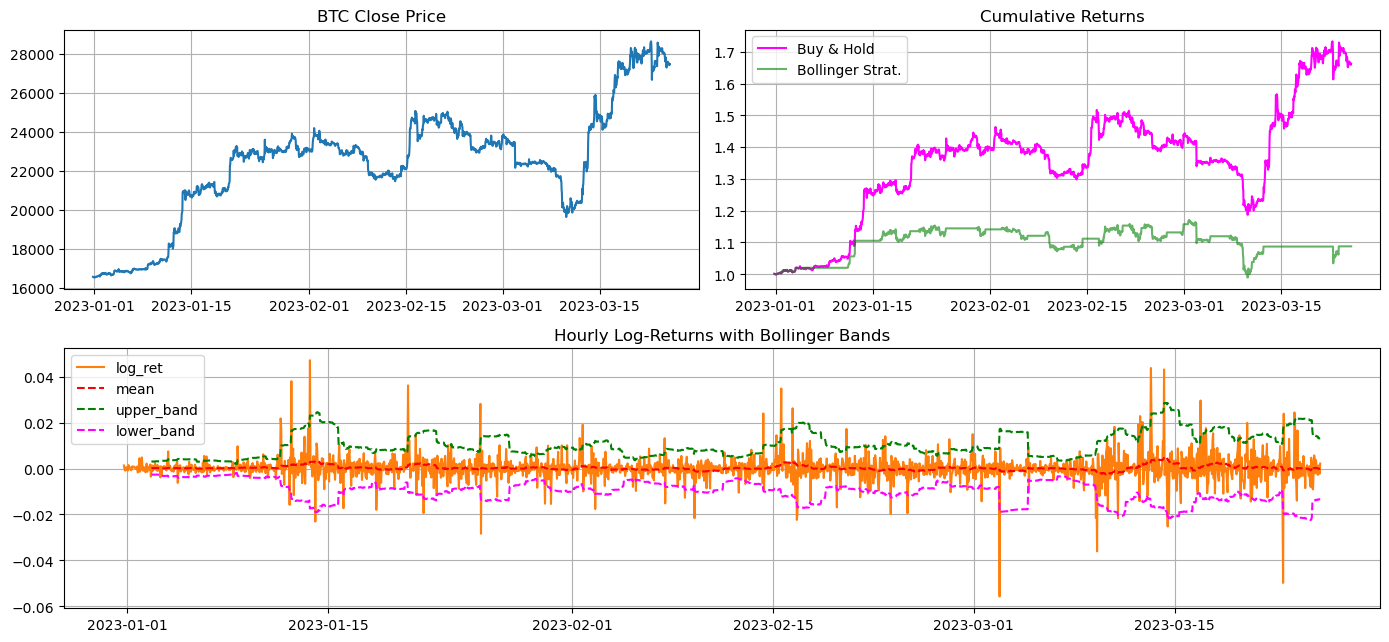

2000 | 2023-03-25 03:00:00-06:00 | Close: 27,481.96 | log_ret:  0.00216 | rsi: 43.25106658128373 | pos: 0


In [ ]:
# ---------------- SET-UP ----------------
ts_x, close_y, logret_y = [], [], []
cstrategy_y, creturns_y = [], []
meanret_y, position_y   = [], []
upperb_y, lowerb_y      = [], []

results_log = []

position  = 1                 # 1 = long ; 0 = flat
cum_asset = 0.0               # cumulative *log* return of BTC
cum_strat = 0.0               # cumulative *log* return of strategy

window = 48     # Bollinger look-back (2 trading day)
k      = 2      # ±k·σ bands

# -------------- MAIN LOOP --------------
for n, data in enumerate(simulate_market(btc, delay=0.05), start=1):
    latest  = data.iloc[-1]
    tstamp  = latest.name
    ret     = latest.log_ret          # for brevity

    # --- P/L accrual with *yesterday’s* stance ---
    cum_asset += ret
    cum_strat += position * ret       # position from previous bar

    creturns_y.append(np.exp(cum_asset))
    cstrategy_y.append(np.exp(cum_strat))

    # ------------ BOLLINGER BLOCK -------------
    if len(data) >= window:
        roll = data['log_ret'].dropna().iloc[-window:]
        mean_ret  = roll.mean()
        std_ret   = roll.std()
        
        # ----- RSI (7-bar) -----
        rsi_val = (
            ta.momentum                     # Indicator family
            .RSIIndicator(close=data['close'], window=7)
            .rsi()                        # <-— get the Series
            .iloc[-1]                     # last value only
        )

        upper_band = mean_ret + k * std_ret
        lower_band = mean_ret - k * std_ret

        # --- trade signal: update *after* booking P/L ---
        if   ret < lower_band and rsi_val < 40:
            position = 1            # long / oversold
        elif ret > upper_band and rsi_val > 70:
            position = 0            # flat / overbought
        # else: keep previous position
    else:
        # not enough data yet → NaNs keep plots aligned
        mean_ret  = upper_band = lower_band = rsi_val = np.nan

    # ------------- LOGGING ARRAYS -------------
    ts_x.append(tstamp)
    close_y.append(latest.close)
    logret_y.append(ret)
    meanret_y.append(mean_ret)
    position_y.append(position)
    upperb_y.append(upper_band)
    lowerb_y.append(lower_band)

    results_log.append({
        "timestamp": tstamp,
        "close":     latest.close,
        "log_ret":   ret,
        "mean_ret":  mean_ret,
        "upper_band": upper_band,
        "lower_band": lower_band,
        "rsi": rsi_val,
        "creturns":  creturns_y[-1],
        "cstrategy": cstrategy_y[-1],
        "position":  position
    })

    # ------------------ PLOTTING ------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])

    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.set_title("BTC Close Price"); ax1.grid(True)

    # 2) Equity curves
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold",      color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="Bollinger Strat.", color="green", alpha=0.6)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + bands
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y,   label="log_ret",  color="tab:orange")
    ax3.plot(ts_x, meanret_y,  label="mean",     color="red", ls="--")
    ax3.plot(ts_x, upperb_y,   label="upper_band", color="green",  ls="--")
    ax3.plot(ts_x, lowerb_y,   label="lower_band", color="magenta",ls="--")
    ax3.set_title("Hourly Log-Returns with Bollinger Bands")
    ax3.legend(); ax3.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close: {latest.close:,.2f} | "
          f"log_ret: {latest.log_ret: .5f} | rsi: {rsi_val} | "
          f"pos: {position}")

    if n == 2000:      # demo stop
        break

# ---------------- FINAL DF ----------------
df_results = (pd.DataFrame(results_log)
              .set_index("timestamp")
              .sort_index())



### 4.3 Analysis of log returns using GARCH(1, 1)

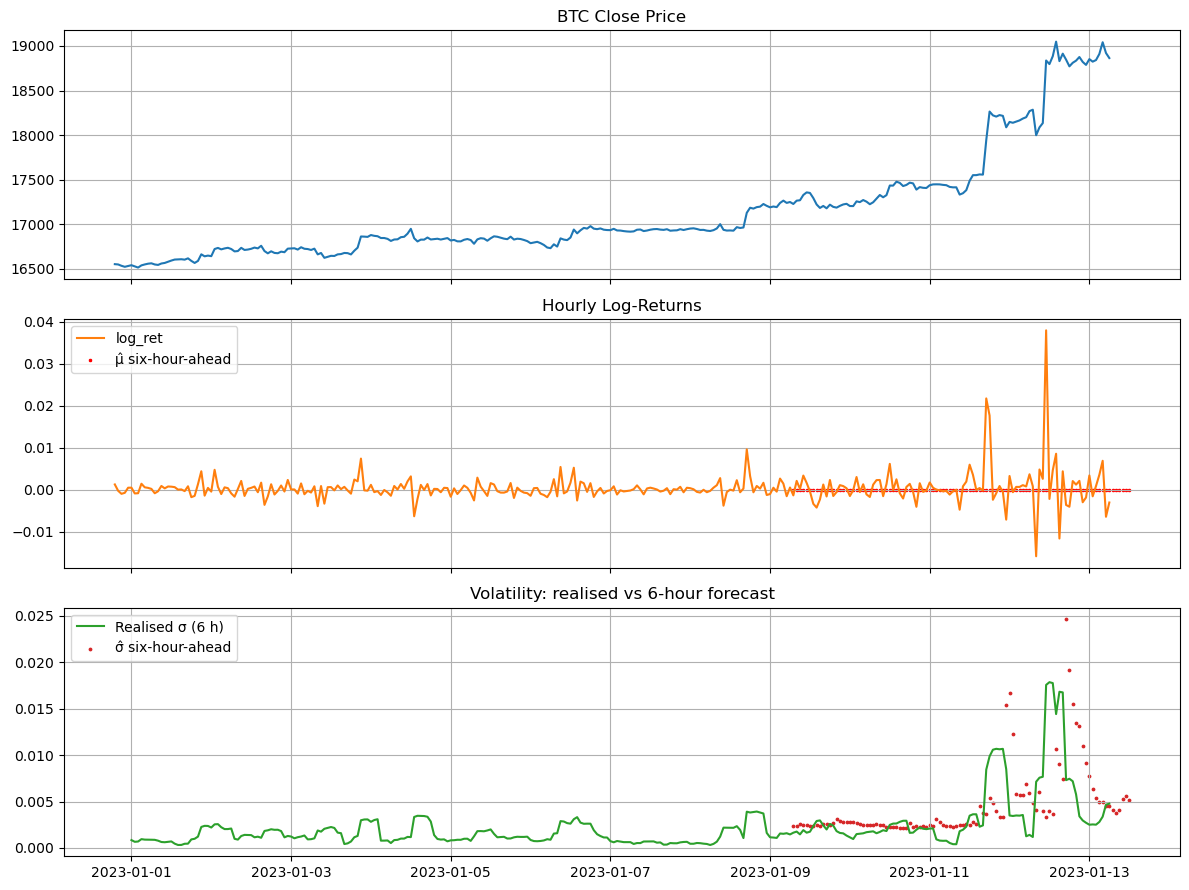

300 | 2023-01-13 06:00:00-06:00 | Close 18,864.59 | log_ret -0.00298 | RV24h  0.00477 | μ̂(t+6h) 3.311901096266793e-05 | σ̂(t+6h) 0.005212821758971778


In [ ]:
# ---------------- containers for plotting ---------------------------
ts_x, close_y, logret_y = [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []                      # one dict = one row in final DF

# --------------------------------------------------------------------
for n, data in enumerate(simulate_market(btc, delay=0.05), start=1):
    latest    = data.iloc[-1]
    tstamp    = latest.name
    realised  = data['log_ret'].rolling(6).std().iloc[-1]

    # ---------- append to plotting lists -----------------------------
    ts_x.append(tstamp);         close_y.append(latest.close)
    logret_y.append(latest.log_ret);   realvol_y.append(realised)

    # ---------- baseline row for DF (actual candle) ------------------
    results_log.append(dict(timestamp      = tstamp,
                            close          = latest.close,
                            log_ret        = latest.log_ret,
                            realized_vol   = realised,
                            forecasted_vol = np.nan,
                            forecasted_mu  = np.nan))   # <- new column

    # ---------- six-hour-ahead forecast ------------------------------
    pred_6h = mu_6h = np.nan
    if len(data) >= 200:
        train = data['log_ret'].dropna().iloc[-200:] * 1000
        res   = arch_model(train, vol='GARCH', p=1, q=1,
                           mean='AR', dist='t', rescale=False).fit(disp='off')


        if res.optimization_result.success:
            fcast  = res.forecast(horizon=6)

            sigma_vec = np.sqrt(fcast.variance.iloc[-1].values) / 1000
            pred_6h   = sigma_vec[5]                    # σ̂

            mu_vec    = fcast.mean.iloc[-1].values / 1000
            mu_6h     = mu_vec[5]                       # μ̂


    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if not np.isnan(pred_6h):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        fcst_x.append(future_ts);   fcst_y.append(pred_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_6h)

        results_log.append(dict(timestamp      = future_ts,
                                close          = np.nan,
                                log_ret        = np.nan,
                                realized_vol   = np.nan,
                                forecasted_vol = pred_6h,
                                forecasted_mu  = mu_6h))

    # ------------------------------ plot ------------------------------
    clear_output(wait=True)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9), sharex=True)


    # 1) Close price
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.set_title("BTC Close Price"); ax1.grid(True)

    # 2) Log-returns + mean forecast
    ax2.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax2.scatter(mean_fcst_x, mean_fcst_y, color="red",
                marker="x", s=3, label="μ̂ six-hour-ahead")
    ax2.set_title("Hourly Log-Returns"); ax2.legend(); ax2.grid(True)

    # 3) Volatility
    ax3.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax3.scatter(fcst_x, fcst_y, color="tab:red",
                marker="o", s=3, label="σ̂ six-hour-ahead")
    ax3.set_title("Volatility: realised vs 6-hour forecast")
    ax3.legend(); ax3.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
          f"log_ret {latest.log_ret: .5f} | RV24h {realised: .5f} | "
          f"μ̂(t+6h) {mu_6h if not np.isnan(mu_6h) else 'nan'} | "
          f"σ̂(t+6h) {pred_6h if not np.isnan(pred_6h) else 'nan'}")

    if n == 300: break

# ------------------------- FINAL DF -------------------------
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index()
                .pipe(lambda df: df[df.index.notnull()]))

df_results.index = df_results.index.floor("h")

df_final = (df_results
              .groupby(level=0)
              .agg(close          = ("close",          "first"),
                   log_ret        = ("log_ret",        "first"),
                   realized_vol   = ("realized_vol",   "first"),
                   forecasted_vol = ("forecasted_vol", "last"),
                   forecasted_mu  = ("forecasted_mu",  "last")))

#### 4.3.1 Adding creturns and cstrategy

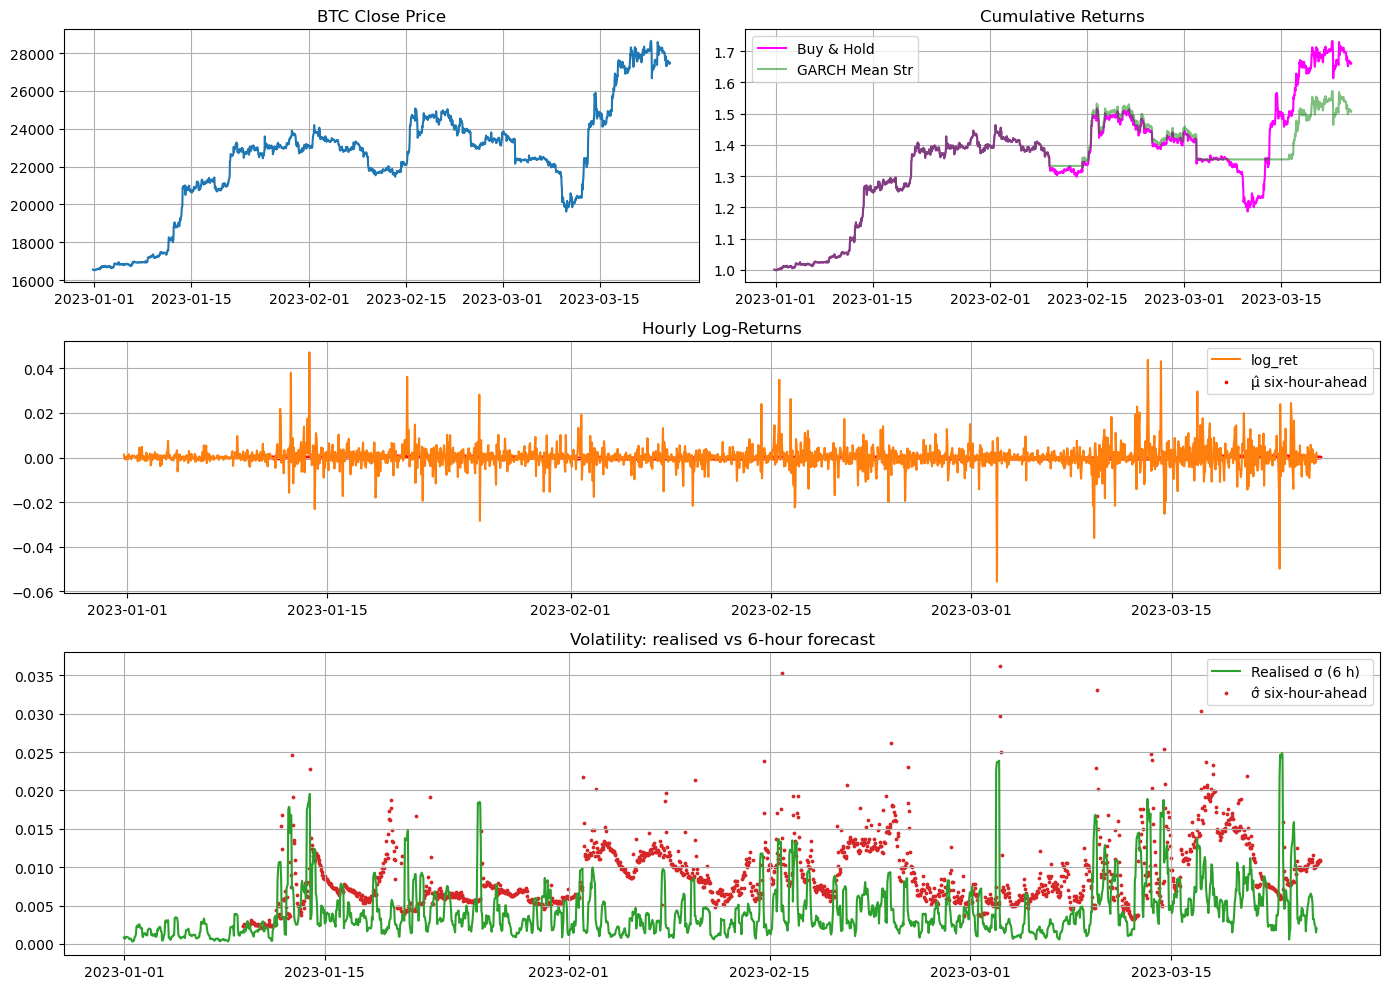

2000 | 2023-03-25 03:00:00-06:00 | Close 27,481.96 | log_ret  0.00216 | RV6h  0.00201 | μ̂(t+6h) 0.0002723529357895646 | σ̂(t+6h) 0.010975591284315038 | position 1


In [ ]:
# ---------------- containers for plotting ---------------------------
ts_x, close_y, logret_y = [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

# --------------------------------------------------------------------
for n, data in enumerate(simulate_market(btc, delay=0.05), start=1):
    latest    = data.iloc[-1]
    tstamp    = latest.name

    prev_pos = position        # use yesterday’s stance for today’s P/L

    # ---------- RETURN ACCRUAL ----------
    cum_asset += latest.log_ret
    cum_strat += prev_pos * latest.log_ret

    creturns_y.append(np.exp(cum_asset))      # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))     # strategy equity curve

    # -------------- realised volatility -----------------------------

    realised  = data['log_ret'].rolling(6).std().iloc[-1]

    # ---------- append to plotting lists -----------------------------
    ts_x.append(tstamp);         close_y.append(latest.close)
    logret_y.append(latest.log_ret);   realvol_y.append(realised)

# ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = latest.log_ret,
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,          # <- add
        cum_asset      = cum_asset,         # <- add
        cum_strat      = cum_strat          # <- add
    ))

    # ---------------- GARCH(1, 1) model ------------------------------
    pred_6h = mu_6h = np.nan
    if len(data) >= 200:
        train = data['log_ret'].dropna().iloc[-200:] * 1000
        res   = arch_model(train, vol='GARCH', p=1, q=1,
                           mean='AR', dist='t', rescale=False).fit(disp='off')

        #-------- if optimizacion success, model fit ------------------
        if res.optimization_result.success:
            fcast  = res.forecast(horizon=6)

            sigma_vec = np.sqrt(fcast.variance.iloc[-1].values) / 1000
            pred_6h   = sigma_vec[5]                    # σ̂

            mu_vec    = fcast.mean.iloc[-1].values / 1000
            mu_6h     = mu_vec[5]                       # μ̂
        
        # ------------ decision logic ----------------------------------
        vol_theshold = 0.020

        if mu_6h > 0:
            position = 1
        elif mu_6h < 0 and pred_6h > vol_theshold:
            position = 0
        # else: keep previous position
            

    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if not np.isnan(pred_6h):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        fcst_x.append(future_ts);   fcst_y.append(pred_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_6h)

        results_log.append(dict(timestamp      = future_ts,
                                close          = np.nan,
                                log_ret        = np.nan,
                                realized_vol   = np.nan,
                                forecasted_vol = pred_6h,
                                forecasted_mu  = mu_6h,
                                position       = position,
                                cum_asset      = cum_asset,
                                cum_strat      = cum_strat))

    # ------------------------------ plot ------------------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="GARCH Mean Str", color="green", alpha=0.5)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.scatter(mean_fcst_x, mean_fcst_y, color="red",
                marker="x", s=3, label="μ̂ six-hour-ahead")
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.scatter(fcst_x, fcst_y, color="tab:red",
                marker="o", s=3, label="σ̂ six-hour-ahead")
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
        f"log_ret {latest.log_ret: .5f} | RV6h {realised: .5f} | "
        f"μ̂(t+6h) {mu_6h if np.isfinite(mu_6h) else 'nan'} | "
        f"σ̂(t+6h) {pred_6h if np.isfinite(pred_6h) else 'nan'} | "
        f"position {position}")

    if n == 2000: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
df_final = (df_results
              .groupby(level=0)
              .agg(close          = ('close',          'first'),
                   log_ret        = ('log_ret',        'first'),
                   realized_vol   = ('realized_vol',   'first'),
                   forecasted_vol = ('forecasted_vol', 'last'),
                   forecasted_mu  = ('forecasted_mu',  'last'),
                   position       = ('position',       'last'),
                   cum_asset      = ('cum_asset',      'last'),
                   cum_strat      = ('cum_strat',      'last'))
              .sort_index())      # keep index in time order

#### 4.3.2 Improving GARCH

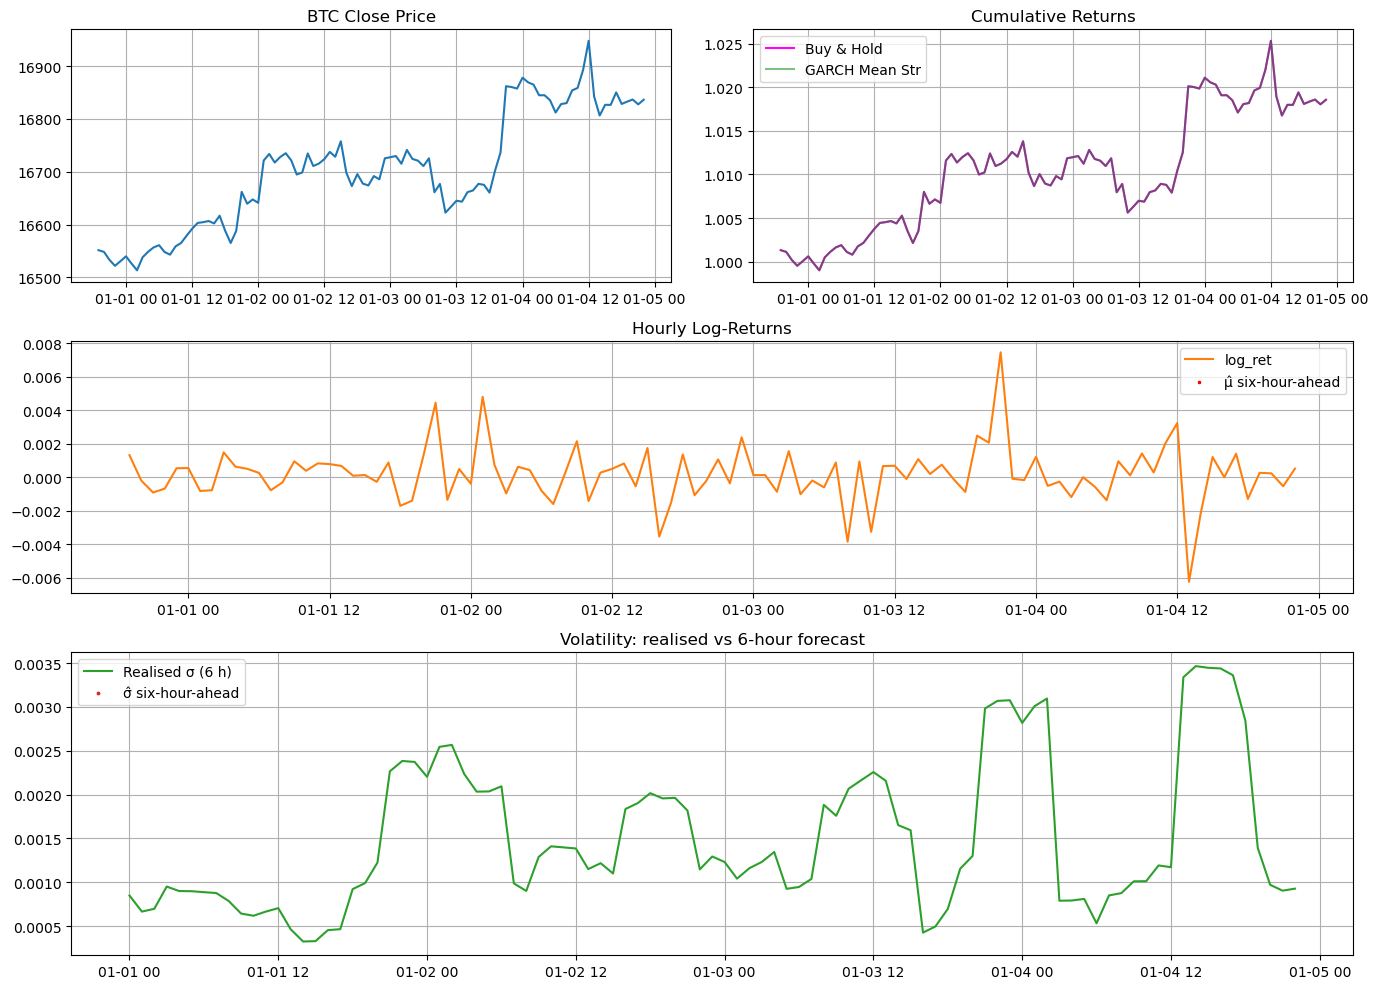

100 | 2023-01-04 22:00:00-06:00 | Close 16,836.41 | log_ret  0.00052 | RV6h  0.00093 | μ̂(t+6h) nan | σ̂(t+6h) nan | position 1


In [ ]:
# ---------------- containers for plotting ---------------------------
ts_x, close_y, logret_y = [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

# --------------------------------------------------------------------
for n, data in enumerate(simulate_market(btc, delay=0.05), start=1):
    latest    = data.iloc[-1]
    tstamp    = latest.name

    prev_pos = position        # use yesterday’s stance for today’s P/L

    # ---------- RETURN ACCRUAL ----------
    cum_asset += latest.log_ret
    cum_strat += prev_pos * latest.log_ret

    creturns_y.append(np.exp(cum_asset))      # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))     # strategy equity curve

    # -------------- realised volatility -----------------------------

    realised  = data['log_ret'].rolling(6).std().iloc[-1]

    # ---------- append to plotting lists -----------------------------
    ts_x.append(tstamp);         close_y.append(latest.close)
    logret_y.append(latest.log_ret);   realvol_y.append(realised)

# ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = latest.log_ret,
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,          # <- add
        cum_asset      = cum_asset,         # <- add
        cum_strat      = cum_strat          # <- add
    ))

    # ---------------- GARCH(1, 1) model ------------------------------
    pred_6h = mu_6h = np.nan
    if len(data) >= 200:
        train = data['log_ret'].dropna().iloc[-200:] * 1000
        res   = arch_model(train, vol='GARCH', p=1, q=1,
                           mean='AR', dist='t', rescale=False).fit(disp='off')

        #-------- if optimizacion success, model fit ------------------
        if res.optimization_result.success:
            fcast  = res.forecast(horizon=6)

            sigma_vec = np.sqrt(fcast.variance.iloc[-1].values) / 1000
            pred_6h   = sigma_vec[5]                    # σ̂

            mu_vec    = fcast.mean.iloc[-1].values / 1000
            mu_6h     = mu_vec[5]                       # μ̂


    # ------------------ dynamic σ_cut, binary stance ------------------
    # ----------------------------------------------------------
    # Dynamic σ_cut: use the 7-day median of realised σ once we
    # have at least one week of data; otherwise fall back to 0.8 %
    # ----------------------------------------------------------
    n_obs = len(realvol_y)                # how many hourly σ values we have

    if n_obs >= 24 * 7:                    # 24 h × 7 d  = 168 observations
        vol_median = (
            pd.Series(realvol_y)           # convert list → Series
            .rolling(24 * 7)             # 7-day rolling window
            .median()
            .iloc[-1]                    # most-recent median
        )
    else:
        vol_median = np.nan               # not enough data yet

    sigma_cut = (1.2 * vol_median          # 20 % safety margin
                if np.isfinite(vol_median)
                else 0.008)               # fallback = 0.8 % per 6 h

    eps            = 0.0001               # tiny mean filter

    # default: keep yesterday’s stance
    new_pos = position

    if np.isfinite(mu_6h) and np.isfinite(pred_6h):
        if mu_6h >  eps:
            new_pos = 1                                   # go / stay LONG
        elif (mu_6h < -eps) and (pred_6h > sigma_cut):
            new_pos = 0                                   # FLAT if downside + high σ
        # else: leave unchanged

    position = int(new_pos)                               # ensure 0 or 1

                    
    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if not np.isnan(pred_6h):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        fcst_x.append(future_ts);   fcst_y.append(pred_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_6h)

        results_log.append(dict(timestamp      = future_ts,
                                close          = np.nan,
                                log_ret        = np.nan,
                                realized_vol   = np.nan,
                                forecasted_vol = pred_6h,
                                forecasted_mu  = mu_6h,
                                position       = position,
                                cum_asset      = cum_asset,
                                cum_strat      = cum_strat))

    # ------------------------------ plot ------------------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="GARCH Mean Str", color="green", alpha=0.5)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.scatter(mean_fcst_x, mean_fcst_y, color="red",
                marker="x", s=3, label="μ̂ six-hour-ahead")
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.scatter(fcst_x, fcst_y, color="tab:red",
                marker="o", s=3, label="σ̂ six-hour-ahead")
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
        f"log_ret {latest.log_ret: .5f} | RV6h {realised: .5f} | "
        f"μ̂(t+6h) {mu_6h if np.isfinite(mu_6h) else 'nan'} | "
        f"σ̂(t+6h) {pred_6h if np.isfinite(pred_6h) else 'nan'} | "
        f"position {position}")

    if n == 100: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
df_final = (df_results
              .groupby(level=0)
              .agg(close          = ('close',          'first'),
                   log_ret        = ('log_ret',        'first'),
                   realized_vol   = ('realized_vol',   'first'),
                   forecasted_vol = ('forecasted_vol', 'last'),
                   forecasted_mu  = ('forecasted_mu',  'last'),
                   position       = ('position',       'last'),
                   cum_asset      = ('cum_asset',      'last'),
                   cum_strat      = ('cum_strat',      'last'))
              .sort_index())      # keep index in time order

#### 4.3.3 Modifying mean returns to rolling mean

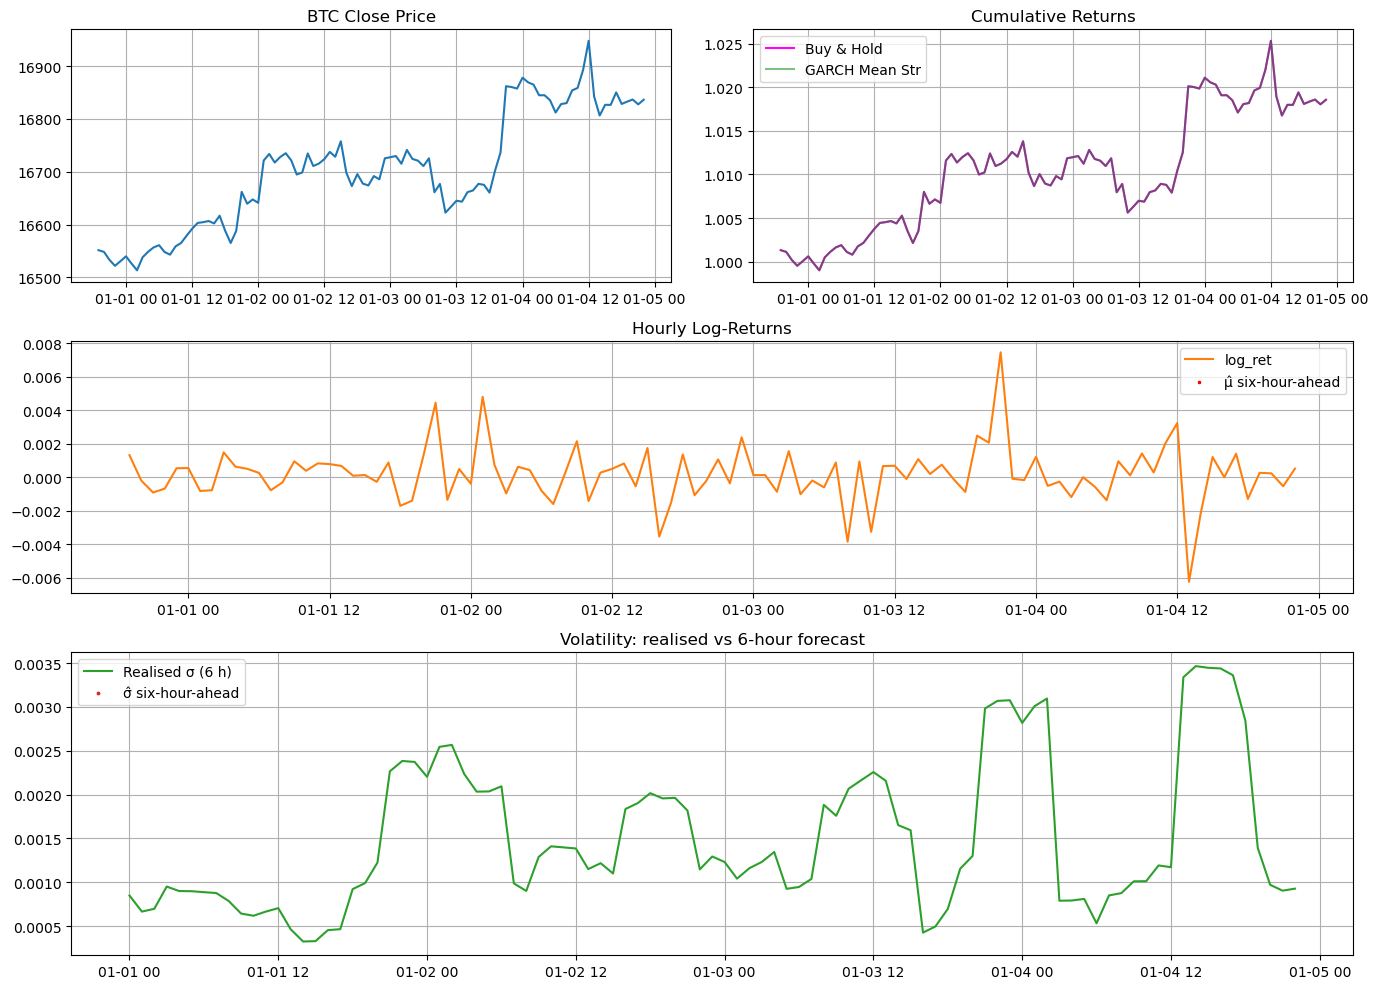

100 | 2023-01-04 22:00:00-06:00 | Close 16,836.41 | log_ret  0.00052 | RV6h  0.00093 | μ̂(t+6h) nan | σ̂(t+6h) nan | position 1


In [ ]:
# ---------------- containers for plotting ---------------------------
ts_x, close_y, logret_y = [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

# --------------------------------------------------------------------
for n, data in enumerate(simulate_market(btc, delay=0.05), start=1):
    latest    = data.iloc[-1]
    tstamp    = latest.name

    prev_pos = position        # use yesterday’s stance for today’s P/L

    # ---------- RETURN ACCRUAL ----------
    cum_asset += latest.log_ret
    cum_strat += prev_pos * latest.log_ret

    creturns_y.append(np.exp(cum_asset))      # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))     # strategy equity curve

    # -------------- realised volatility -----------------------------

    realised  = data['log_ret'].rolling(6).std().iloc[-1]

    # ---------- append to plotting lists -----------------------------
    ts_x.append(tstamp);         close_y.append(latest.close)
    logret_y.append(latest.log_ret);   realvol_y.append(realised)

# ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = latest.log_ret,
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,          # <- add
        cum_asset      = cum_asset,         # <- add
        cum_strat      = cum_strat          # <- add
    ))

    # ---------------- GARCH(1, 1) model ------------------------------
    pred_6h = mu_6h = np.nan
    if len(data) >= 200:
        train = data['log_ret'].dropna().iloc[-200:] * 1000
        res   = arch_model(train, vol='GARCH', p=1, q=1,
                           mean='AR', dist='t', rescale=False).fit(disp='off')

        #-------- if optimizacion success, model fit ------------------
        if res.optimization_result.success:
            fcast  = res.forecast(horizon=6)

            sigma_vec = np.sqrt(fcast.variance.iloc[-1].values) / 1000
            pred_6h   = sigma_vec[5]                    # σ̂

            mu_6h     = data['log_ret'].rolling(6).mean().iloc[-1]                       # μ̂


    # ------------------ dynamic σ_cut, binary stance ------------------
    # ----------------------------------------------------------
    # Dynamic σ_cut: use the 7-day median of realised σ once we
    # have at least one week of data; otherwise fall back to 0.8 %
    # ----------------------------------------------------------
    n_obs = len(realvol_y)                # how many hourly σ values we have

    if n_obs >= 24 * 7:                    # 24 h × 7 d  = 168 observations
        vol_median = (
            pd.Series(realvol_y)           # convert list → Series
            .rolling(24 * 7)             # 7-day rolling window
            .median()
            .iloc[-1]                    # most-recent median
        )
    else:
        vol_median = np.nan               # not enough data yet

    sigma_cut = (1.2 * vol_median          # 20 % safety margin
                if np.isfinite(vol_median)
                else 0.008)               # fallback = 0.8 % per 6 h

    eps            = 0.0001               # tiny mean filter

    # default: keep yesterday’s stance
    new_pos = position

    if np.isfinite(mu_6h) and np.isfinite(pred_6h):
        if mu_6h >  eps:
            new_pos = 1                                   # go / stay LONG
        elif (mu_6h < -eps) and (pred_6h > sigma_cut):
            new_pos = 0                                   # FLAT if downside + high σ
        # else: leave unchanged

    position = int(new_pos)                               # ensure 0 or 1

                    
    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if not np.isnan(pred_6h):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        fcst_x.append(future_ts);   fcst_y.append(pred_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_6h)

        results_log.append(dict(timestamp      = future_ts,
                                close          = np.nan,
                                log_ret        = np.nan,
                                realized_vol   = np.nan,
                                forecasted_vol = pred_6h,
                                forecasted_mu  = mu_6h,
                                position       = position,
                                cum_asset      = cum_asset,
                                cum_strat      = cum_strat))

    # ------------------------------ plot ------------------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="GARCH Mean Str", color="green", alpha=0.5)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.scatter(mean_fcst_x, mean_fcst_y, color="red",
                marker="x", s=3, label="μ̂ six-hour-ahead")
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.scatter(fcst_x, fcst_y, color="tab:red",
                marker="o", s=3, label="σ̂ six-hour-ahead")
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
        f"log_ret {latest.log_ret: .5f} | RV6h {realised: .5f} | "
        f"μ̂(t+6h) {mu_6h if np.isfinite(mu_6h) else 'nan'} | "
        f"σ̂(t+6h) {pred_6h if np.isfinite(pred_6h) else 'nan'} | "
        f"position {position}")

    if n == 100: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
df_final = (df_results
              .groupby(level=0)
              .agg(close          = ('close',          'first'),
                   log_ret        = ('log_ret',        'first'),
                   realized_vol   = ('realized_vol',   'first'),
                   forecasted_vol = ('forecasted_vol', 'last'),
                   forecasted_mu  = ('forecasted_mu',  'last'),
                   position       = ('position',       'last'),
                   cum_asset      = ('cum_asset',      'last'),
                   cum_strat      = ('cum_strat',      'last'))
              .sort_index())      # keep index in time order

#### 4.3.4 Using EGARCH

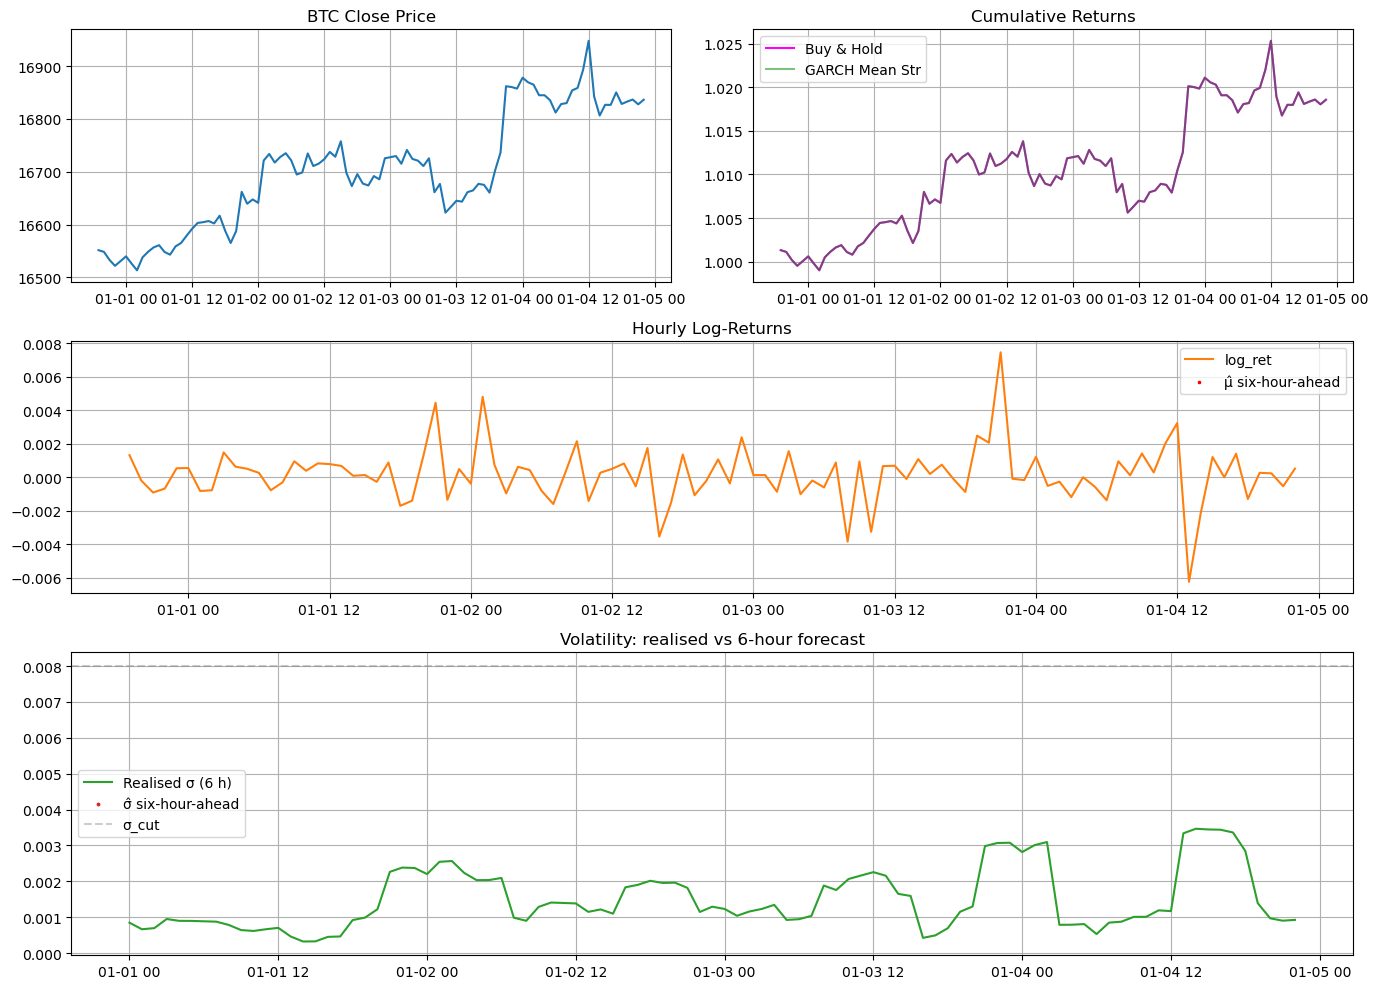

100 | 2023-01-04 22:00:00-06:00 | Close 16,836.41 | log_ret  0.00052 | RV6h  0.00093 | μ̂(t+6h) nan | σ̂(t+6h) nan | position 1


In [ ]:
# ---------------- containers for plotting ---------------------------
ts_x, close_y, logret_y = [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

# --------------------------------------------------------------------
for n, data in enumerate(simulate_market(btc, delay=0.05), start=1):
    latest    = data.iloc[-1]
    tstamp    = latest.name

    prev_pos = position        # use yesterday’s stance for today’s P/L

    # ---------- RETURN ACCRUAL ----------
    cum_asset += latest.log_ret
    cum_strat += prev_pos * latest.log_ret

    creturns_y.append(np.exp(cum_asset))      # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))     # strategy equity curve

    # -------------- realised volatility -----------------------------

    realised  = data['log_ret'].rolling(6).std().iloc[-1]

    # ---------- append to plotting lists -----------------------------
    ts_x.append(tstamp);         close_y.append(latest.close)
    logret_y.append(latest.log_ret);   realvol_y.append(realised)

# ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = latest.log_ret,
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,          # <- add
        cum_asset      = cum_asset,         # <- add
        cum_strat      = cum_strat          # <- add
    ))

    # ---------------- EGARCH(1, 1, 1) model ------------------------------
    pred_6h = mu_6h = np.nan
    if len(data) >= 200:
        train = data['log_ret'].dropna().iloc[-200:] * 1000
        res   = arch_model(train, vol='EGARCH', p=1, o=1, q=1,
                           mean='Zero', dist='t', rescale=False).fit(disp='off')

        #-------- if optimizacion success, model fit ------------------
        if res.optimization_result.success:
            fcast  = res.forecast(horizon=1)

            pred_6h = np.sqrt(fcast.variance.iloc[-1, 0]) / 1000      # σ̂

            mu_6h   = data['log_ret'].rolling(6).mean().iloc[-1]    # μ̂


    # ------------------ dynamic σ_cut, binary stance ------------------
    # ----------------------------------------------------------
    # Dynamic σ_cut: use the 7-day median of realised σ once we
    # have at least one week of data; otherwise fall back to 0.8 %
    # ----------------------------------------------------------
    n_obs = len(realvol_y)                # how many hourly σ values we have

    if n_obs >= 24 * 7:                    # 24 h × 7 d  = 168 observations
        vol_median = (
            pd.Series(realvol_y)           # convert list → Series
            .rolling(24 * 7)             # 7-day rolling window
            .median()
            .iloc[-1]                    # most-recent median
        )
    else:
        vol_median = np.nan               # not enough data yet

    sigma_cut = pd.Series(realvol_y).rolling(168).quantile(0.75).iloc[-1] if n_obs >= 168 else 0.008

    eps            = 0.0001               # tiny mean filter

    # default: keep yesterday’s stance
    new_pos = position

    if np.isfinite(mu_6h) and np.isfinite(pred_6h):
        if mu_6h >  eps:
            new_pos = 1                                   # go / stay LONG
        elif mu_6h < -eps:
            new_pos = 0 if pred_6h > sigma_cut else position  # flat only if downside + high risk
        # else: leave unchanged

    position = int(new_pos)                               # ensure 0 or 1

                    
    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if not np.isnan(pred_6h):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        fcst_x.append(future_ts);   fcst_y.append(pred_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_6h)

        results_log.append(dict(timestamp      = future_ts,
                                close          = np.nan,
                                log_ret        = np.nan,
                                realized_vol   = np.nan,
                                forecasted_vol = pred_6h,
                                forecasted_mu  = mu_6h,
                                position       = position,
                                cum_asset      = cum_asset,
                                cum_strat      = cum_strat))

    # ------------------------------ plot ------------------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="GARCH Mean Str", color="green", alpha=0.5)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.scatter(mean_fcst_x, mean_fcst_y, color="red",
                marker="x", s=3, label="μ̂ six-hour-ahead")
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.scatter(fcst_x, fcst_y, color="tab:red",
                marker="o", s=3, label="σ̂ six-hour-ahead")
    ax4.axhline(sigma_cut, linestyle='--', color='gray', alpha=0.4, label='σ_cut')
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
        f"log_ret {latest.log_ret: .5f} | RV6h {realised: .5f} | "
        f"μ̂(t+6h) {mu_6h if np.isfinite(mu_6h) else 'nan'} | "
        f"σ̂(t+6h) {pred_6h if np.isfinite(pred_6h) else 'nan'} | "
        f"position {position}")

    if n == 100: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
df_final = (df_results
              .groupby(level=0)
              .agg(close          = ('close',          'first'),
                   log_ret        = ('log_ret',        'first'),
                   realized_vol   = ('realized_vol',   'first'),
                   forecasted_vol = ('forecasted_vol', 'last'),
                   forecasted_mu  = ('forecasted_mu',  'last'),
                   position       = ('position',       'last'),
                   cum_asset      = ('cum_asset',      'last'),
                   cum_strat      = ('cum_strat',      'last'))
              .sort_index())      # keep index in time order

#### 4.3.5 Rolling mean and GARCH

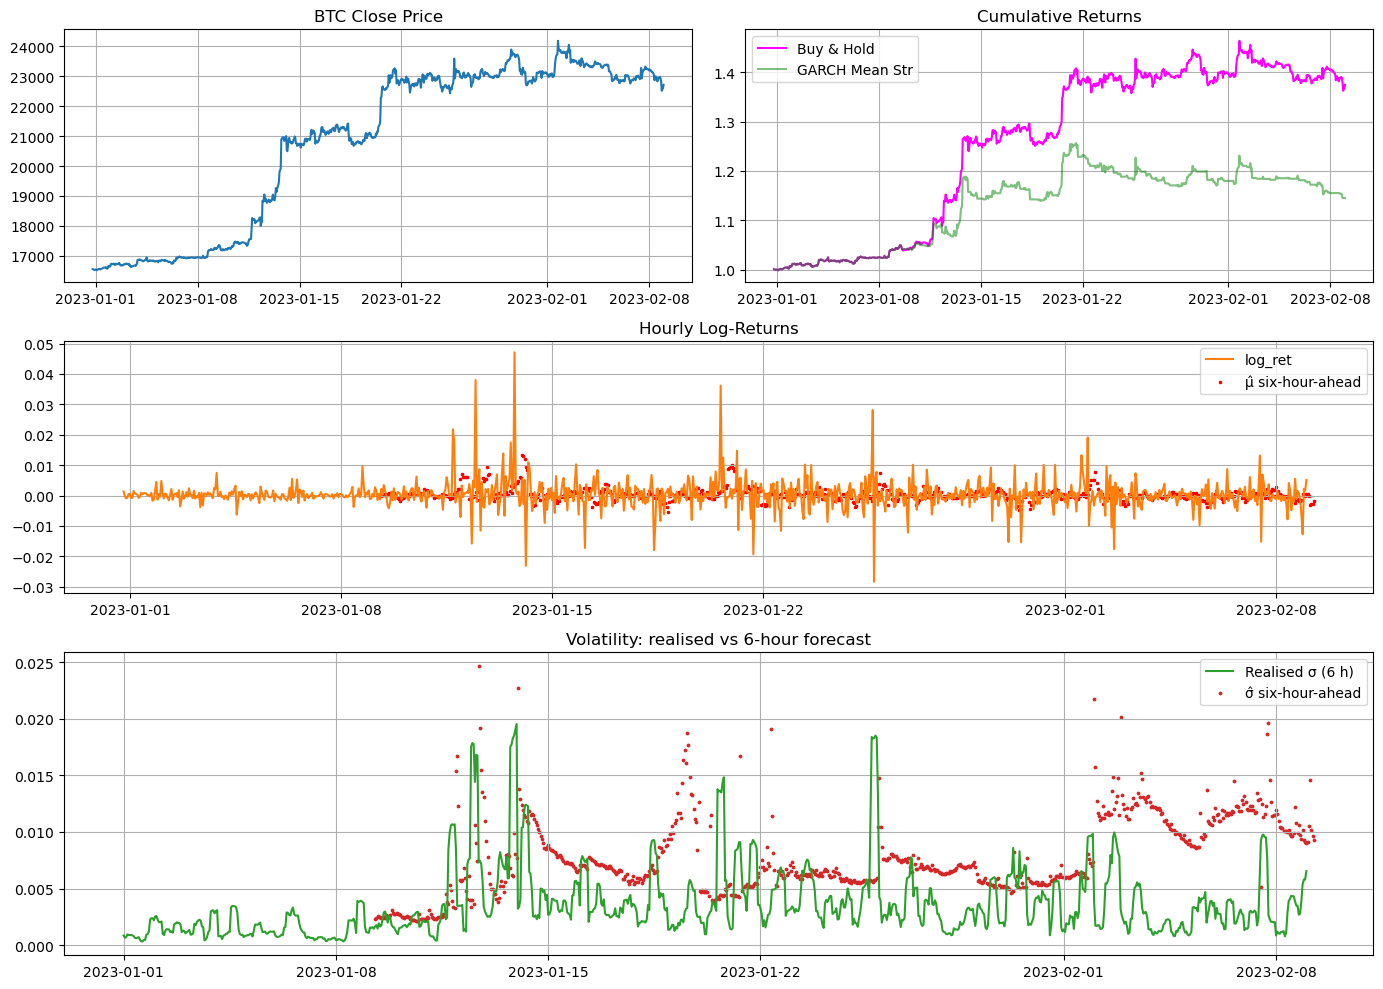

942 | 2023-02-09 00:00:00-06:00 | Close 22,719.25 | log_ret  0.00513 | RV6h  0.00654 | μ̂(t+6h) -0.0019065899321167095 | σ̂(t+6h) 0.00928894038949121 | position 0


KeyboardInterrupt: 

In [ ]:
# ---------------- containers for plotting ---------------------------
ts_x, close_y, logret_y = [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

cooldown = 0                  # bars left before re-entry is allowed
cooldown_max = 6              # 6 bars = 6 hours of cooldown

# --------------------------------------------------------------------
for n, data in enumerate(simulate_market(btc, delay=0.05), start=1):
    latest    = data.iloc[-1]
    tstamp    = latest.name

    prev_pos = position        # use yesterday’s stance for today’s P/L

    # ---------- RETURN ACCRUAL ----------
    cum_asset += latest.log_ret
    cum_strat += prev_pos * latest.log_ret

    creturns_y.append(np.exp(cum_asset))      # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))     # strategy equity curve

    # -------------- realised volatility -----------------------------

    realised  = data['log_ret'].rolling(6).std().iloc[-1]

    # ---------- append to plotting lists -----------------------------
    ts_x.append(tstamp);         close_y.append(latest.close)
    logret_y.append(latest.log_ret);   realvol_y.append(realised)

# ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = latest.log_ret,
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,          # <- add
        cum_asset      = cum_asset,         # <- add
        cum_strat      = cum_strat          # <- add
    ))

    # ---------------- GARCH(1, 1) model ------------------------------
    pred_6h = mu_6h = np.nan
    if len(data) >= 200:
        train = data['log_ret'].dropna().iloc[-200:] * 1000
        res   = arch_model(train, vol='GARCH', p=1, q=1,
                           mean='Zero', dist='t', rescale=False).fit(disp='off')

        #-------- if optimizacion success, model fit ------------------
        if res.optimization_result.success:
            fcast  = res.forecast(horizon=6)

            sigma_vec = np.sqrt(fcast.variance.iloc[-1].values) / 1000
            pred_6h   = sigma_vec[5]                                      # σ̂

            mu_6h     = data['log_ret'].rolling(6).mean().iloc[-1]        # μ̂


    # ------------------ dynamic σ_cut, binary stance ------------------
    # ----------------------------------------------------------
    # Dynamic σ_cut: use the 7-day median of realised σ once we
    # have at least one week of data; otherwise fall back to 0.8 %
    # ----------------------------------------------------------
    n_obs = len(realvol_y)                # how many hourly σ values we have

    if n_obs >= 24 * 7:                    # 24 h × 7 d  = 168 observations
        vol_median = (
            pd.Series(realvol_y)           # convert list → Series
            .rolling(24 * 7)             # 7-day rolling window
            .median()
            .iloc[-1]                    # most-recent median
        )
    else:
        vol_median = np.nan               # not enough data yet

    sigma_cut = (1.2 * vol_median          # 20 % safety margin
                if np.isfinite(vol_median)
                else 0.008)               # fallback = 0.8 % per 6 h

    eps            = 0.0001               # tiny mean filter


    # default: keep yesterday’s stance
    new_pos = position

    if np.isfinite(mu_6h) and np.isfinite(pred_6h):
        if mu_6h >  eps:
            new_pos = 1                                   # go / stay LONG
        elif mu_6h < -eps:
            new_pos = 0 if pred_6h > sigma_cut else position  # flat only if downside + high risk
        # else: leave unchanged


    position = int(new_pos)                               # ensure 0 or 1

                    
    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if not np.isnan(pred_6h):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        fcst_x.append(future_ts);   fcst_y.append(pred_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_6h)

        results_log.append(dict(timestamp      = future_ts,
                                close          = np.nan,
                                log_ret        = np.nan,
                                realized_vol   = np.nan,
                                forecasted_vol = pred_6h,
                                forecasted_mu  = mu_6h,
                                position       = position,
                                cum_asset      = cum_asset,
                                cum_strat      = cum_strat))

    # ------------------------------ plot ------------------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="GARCH Mean Str", color="green", alpha=0.5)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.scatter(mean_fcst_x, mean_fcst_y, color="red",
                marker="x", s=3, label="μ̂ six-hour-ahead")
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.scatter(fcst_x, fcst_y, color="tab:red",
                marker="o", s=3, label="σ̂ six-hour-ahead")
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
        f"log_ret {latest.log_ret: .5f} | RV6h {realised: .5f} | "
        f"μ̂(t+6h) {mu_6h if np.isfinite(mu_6h) else 'nan'} | "
        f"σ̂(t+6h) {pred_6h if np.isfinite(pred_6h) else 'nan'} | "
        f"position {position}")

    if n == 2000: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
df_final = (df_results
              .groupby(level=0)
              .agg(close          = ('close',          'first'),
                   log_ret        = ('log_ret',        'first'),
                   realized_vol   = ('realized_vol',   'first'),
                   forecasted_vol = ('forecasted_vol', 'last'),
                   forecasted_mu  = ('forecasted_mu',  'last'),
                   position       = ('position',       'last'),
                   cum_asset      = ('cum_asset',      'last'),
                   cum_strat      = ('cum_strat',      'last'))
              .sort_index())      # keep index in time order

#### 4.3.6 Confirmation of position

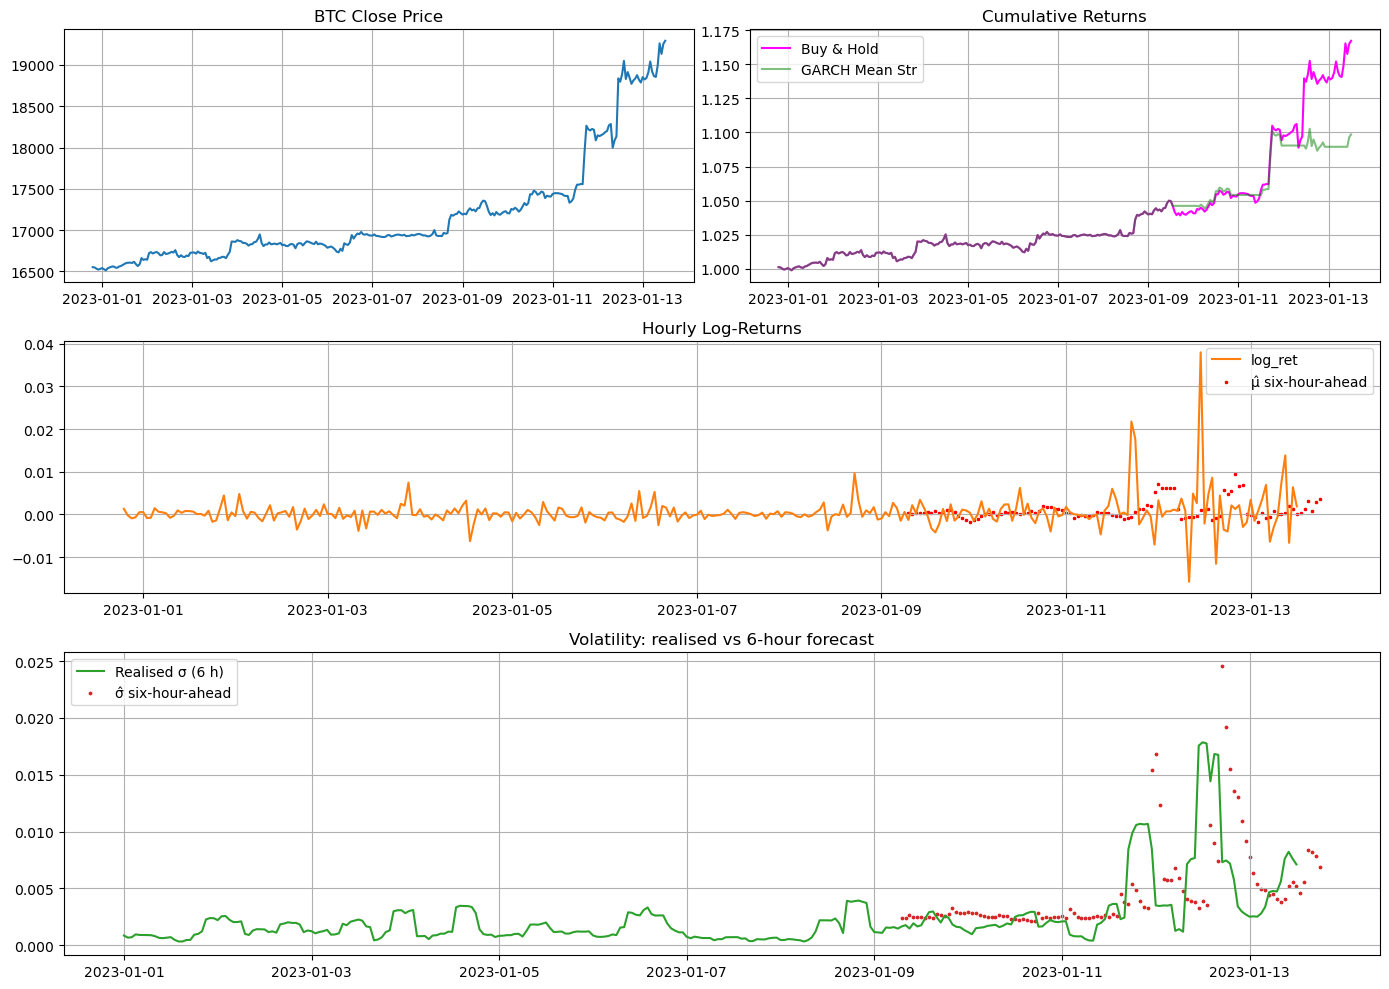

306 | 2023-01-13 12:00:00-06:00 | Close 19,292.44 | log_ret  0.00189 | RV6h  0.00711 | μ̂(t+6h) 0.003737781586085093 | σ̂(t+6h) 0.006864887954660931 | position 1
Exit flag detected — stopping.


In [ ]:
def robust_z_score(x, window=6):
    x_window = x[-window:]
    median = np.median(x_window)
    mad = np.median(np.abs(x_window - median))
    current = x_window[-1]
    
    if mad == 0:
        return 0  # avoid div by zero

    return 0.6745 * (current - median) / mad

# ---------------- containers for plotting ---------------------------
ts_x, close_y, logret_y = [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
decision_log = []
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

cooldown = 0                  # bars left before re-entry is allowed

# --------------------------------------------------------------------
for n, data in enumerate(simulate_market(btc, delay=0.05), start=1):
    latest    = data.iloc[-1]
    tstamp    = latest.name

    prev_pos = position        # use yesterday’s stance for today’s P/L

    # ---------- RETURN ACCRUAL ----------
    cum_asset += latest.log_ret
    cum_strat += prev_pos * latest.log_ret

    creturns_y.append(np.exp(cum_asset))      # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))     # strategy equity curve

    # -------------- realised volatility -----------------------------

    realised  = data['log_ret'].rolling(6).std().iloc[-1]

    # ---------- append to plotting lists -----------------------------
    ts_x.append(tstamp);         close_y.append(latest.close)
    logret_y.append(latest.log_ret);   realvol_y.append(realised)

# ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = latest.log_ret,
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,          # <- add
        cum_asset      = cum_asset,         # <- add
        cum_strat      = cum_strat          # <- add
    ))


    pred_6h = mu_6h = np.nan
    if len(data) >= 200:

    # ---------------- ARMA(1, 1) model ------------------------------
        ret_series = data['log_ret'].dropna().iloc[-200:]
        try:
            arima_model = ARIMA(ret_series, order=(1,0,1)).fit()
            mu_6h = arima_model.forecast(steps=6).mean()
        except:
            mu_6h = np.nan

    # ---------------- GARCH(1, 1) model ------------------------------


        train = data['log_ret'].dropna().iloc[-200:] * 1000
        res   = arch_model(train, vol='GARCH', p=1, q=1,
                           mean='Zero', dist='t', rescale=False).fit(disp='off')

        #-------- if optimizacion success, model fit ------------------
        if res.optimization_result.success:
            fcast  = res.forecast(horizon=6)

            sigma_vec = np.sqrt(fcast.variance.iloc[-1].values) / 1000
            pred_6h   = sigma_vec[5]                                      # σ̂


    # --- Trend confirmation logic (Option 2)
    trend_window = 12  # use 12-hour moving average
    if len(data) >= trend_window:
        trend = data['close'].iloc[-1] - data['close'].rolling(trend_window).mean().iloc[-1]
    else:
        trend = 0

    # --- RZ-score logic
    if len(data) >= 6:
        rz_score = robust_z_score(data['log_ret'].dropna().values, window=6)
    else:
        rz_score = 0

    # ------------------ dynamic σ_cut, binary stance ------------------
    # ----------------------------------------------------------
    # Dynamic σ_cut: use the 7-day median of realised σ once we
    # have at least one week of data; otherwise fall back to 0.8 %
    # ----------------------------------------------------------
    n_obs = len(realvol_y)                # how many hourly σ values we have

    if n_obs >= 24 * 7:                    # 24 h × 7 d  = 168 observations
        vol_median = (
            pd.Series(realvol_y)           # convert list → Series
            .rolling(24 * 7)             # 7-day rolling window
            .median()
            .iloc[-1]                    # most-recent median
        )
    else:
        vol_median = np.nan               # not enough data yet

    sigma_cut = (1.2 * vol_median          # 20 % safety margin
                if np.isfinite(vol_median)
                else 0.008)               # fallback = 0.8 % per 6 h

    eps            = 0.0001               # tiny mean filter


    # default: keep yesterday’s stance
    new_pos = position

    if np.isfinite(mu_6h) and np.isfinite(pred_6h):

        cooldown_max = int(np.clip(pred_6h / sigma_cut * 6, 3, 12))  # Adaptive cooldown

        # --- Case 1: We're currently long
        if position == 1:
            # Exit only if:
            # 1. Expected return is negative
            # 2. Trend is downward
            # 3. Volatility is high
            # OR: there's a sudden extreme drop
            if (
                (mu_6h < -eps and trend < 0 and pred_6h > sigma_cut) or
                (rz_score < -2 and pred_6h > sigma_cut)
            ):
                new_pos = 0
                cooldown = cooldown_max
                print(f"[{tstamp}] EXIT → μ_6h={mu_6h:.5f}, σ̂={pred_6h:.5f}, z={rz_score:.2f}, trend={trend:.2f}")

        # --- Case 2: We're flat and cooldown expired
        elif position == 0 and cooldown == 0:

            short_momentum = data['log_ret'].rolling(6).sum().iloc[-1]
            long_momentum = data['log_ret'].rolling(24).sum().iloc[-1]

            # enter position if strong momentum across multiple horizons
            if mu_6h > eps and trend > 0 and short_momentum > 0 and long_momentum > 0:
                new_pos = 1
                print(f"[{tstamp}] RE-ENTER → μ_6h={mu_6h:.5f}, trend={trend:.2f}, short momentum={short_momentum:.5f}, , long momentum={long_momentum:.5f}")

    # Decrease cooldown timer
    if cooldown > 0:
        cooldown -= 1

    position = int(new_pos)                               # ensure 0 or 1

    decision_log.append({
        "timestamp": tstamp,
        "prev_position": prev_pos,
        "new_position": new_pos,
        "mu_6h": mu_6h,
        "pred_6h": pred_6h,
        "rz_score": rz_score,
        "trend": trend,
        "sigma_cut": sigma_cut,
        "cooldown": cooldown,
        "reason": (
            "RE-ENTER due to μ̂ > eps" if new_pos == 1 and prev_pos == 0 else
            "EXIT due to μ̂ < -eps and σ̂ > threshold" if new_pos == 0 and prev_pos == 1 else
            "COOLDOWN active" if cooldown > 0 else
            "KEEP previous stance"
        )
    })

                    
    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if not np.isnan(pred_6h):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        fcst_x.append(future_ts);   fcst_y.append(pred_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_6h)

        results_log.append(dict(timestamp      = future_ts,
                                close          = np.nan,
                                log_ret        = np.nan,
                                realized_vol   = np.nan,
                                forecasted_vol = pred_6h,
                                forecasted_mu  = mu_6h,
                                position       = position,
                                cum_asset      = cum_asset,
                                cum_strat      = cum_strat))

    # ------------------------------ plot ------------------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="GARCH Mean Str", color="green", alpha=0.5)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.scatter(mean_fcst_x, mean_fcst_y, color="red",
                marker="x", s=3, label="μ̂ six-hour-ahead")
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.scatter(fcst_x, fcst_y, color="tab:red",
                marker="o", s=3, label="σ̂ six-hour-ahead")
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
        f"log_ret {latest.log_ret: .5f} | RV6h {realised: .5f} | "
        f"μ̂(t+6h) {mu_6h if np.isfinite(mu_6h) else 'nan'} | "
        f"σ̂(t+6h) {pred_6h if np.isfinite(pred_6h) else 'nan'} | "
        f"position {position}")

    # Auto-stop via file flag
    if os.path.exists("exit.flag"):
        print("Exit flag detected — stopping.")
        break

    if n == 2000: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
df_final = (df_results
              .groupby(level=0)
              .agg(close          = ('close',          'first'),
                   log_ret        = ('log_ret',        'first'),
                   realized_vol   = ('realized_vol',   'first'),
                   forecasted_vol = ('forecasted_vol', 'last'),
                   forecasted_mu  = ('forecasted_mu',  'last'),
                   position       = ('position',       'last'),
                   cum_asset      = ('cum_asset',      'last'),
                   cum_strat      = ('cum_strat',      'last'))
              .sort_index())      # keep index in time order

df_decision_log = pd.DataFrame(decision_log)

In [94]:
df_decision_log

timestamp  prev_position  new_position     mu_6h  \
0   2022-12-31 19:00:00-06:00              1             1       NaN   
1   2022-12-31 20:00:00-06:00              1             1       NaN   
2   2022-12-31 21:00:00-06:00              1             1       NaN   
3   2022-12-31 22:00:00-06:00              1             1       NaN   
4   2022-12-31 23:00:00-06:00              1             1       NaN   
..                        ...            ...           ...       ...   
359 2023-01-15 18:00:00-06:00              1             1  0.001186   
360 2023-01-15 19:00:00-06:00              1             1  0.002479   
361 2023-01-15 20:00:00-06:00              1             1  0.002403   
362 2023-01-15 21:00:00-06:00              1             0  0.001390   
363 2023-01-15 22:00:00-06:00              0             0  0.001884   

      pred_6h  rz_score       trend  sigma_cut  cooldown  \
0         NaN  0.000000    0.000000   0.008000         0   
1         NaN  0.000000    0.000000   0.008000         0   
2         NaN  0.000000    0.000000   0.008000         0   
3         NaN  0.000000    0.000000   0.008000         0   
4         NaN  0.690069    0.000000   0.008000         0   
..        ...       ...         ...        ...       ...   
359  0.019498  1.412765   97.010833   0.003561         0   
360  0.007097  3.348089  273.544167   0.003561         0   
361  0.006978  0.196075  264.840000   0.003561         0   
362  0.007143 -2.361639  117.260000   0.003561        23   
363  0.007114  0.837048  167.254167   0.003561        22   

                                       reason  
0                        KEEP previous stance  
1                        KEEP previous stance  
2                        KEEP previous stance  
3                        KEEP previous stance  
4                        KEEP previous stance  
..                                        ...  
359                      KEEP previous stance  
360                      KEEP previous stance  
361                      KEEP previous stance  
362  EXIT due to μ̂ < -eps and σ̂ > threshold  
363                           COOLDOWN active  

[364 rows x 10 columns]

#### 4.3.7 Enhacing previous model

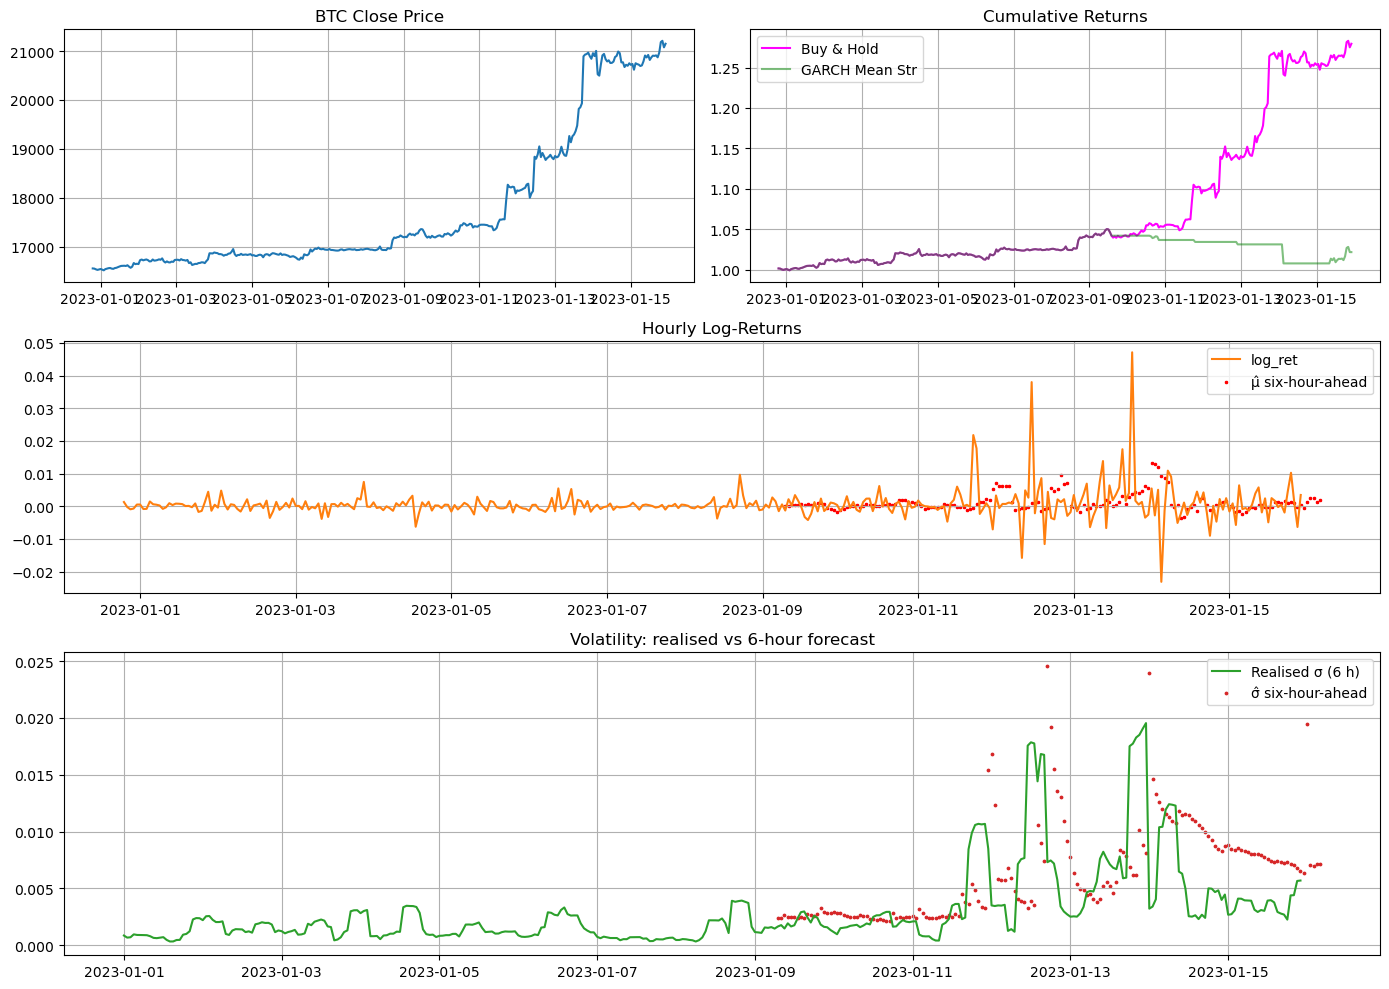

364 | 2023-01-15 22:00:00-06:00 | Close 21,148.99 | log_ret  0.00347 | RV6h  0.00569 | μ̂(t+6h) 0.0018839836881719763 | σ̂(t+6h) 0.007113709124493656 | position 0
Exit flag detected — stopping.


In [ ]:
def robust_z_score(x, window=6):
    x_window = x[-window:]
    median = np.median(x_window)
    mad = np.median(np.abs(x_window - median))
    current = x_window[-1]
    
    if mad == 0:
        return 0  # avoid div by zero

    return 0.6745 * (current - median) / mad

# ---------------- containers for plotting ---------------------------
ts_x, close_y, logret_y = [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
decision_log = []
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

cooldown = 0                  # bars left before re-entry is allowed

# --------------------------------------------------------------------
for n, data in enumerate(simulate_market(btc, delay=0.05), start=1):
    latest    = data.iloc[-1]
    tstamp    = latest.name

    prev_pos = position        # use yesterday’s stance for today’s P/L

    # ---------- RETURN ACCRUAL ----------
    cum_asset += latest.log_ret
    cum_strat += prev_pos * latest.log_ret

    creturns_y.append(np.exp(cum_asset))      # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))     # strategy equity curve

    # -------------- realised volatility -----------------------------

    realised  = data['log_ret'].rolling(6).std().iloc[-1]

    # ---------- append to plotting lists -----------------------------
    ts_x.append(tstamp);         close_y.append(latest.close)
    logret_y.append(latest.log_ret);   realvol_y.append(realised)

# ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = latest.log_ret,
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,          # <- add
        cum_asset      = cum_asset,         # <- add
        cum_strat      = cum_strat          # <- add
    ))

    # ---------------- GARCH(1, 1) model ------------------------------
    pred_6h = mu_6h = np.nan
    if len(data) >= 200:
        train = data['log_ret'].dropna().iloc[-200:] * 1000
        res   = arch_model(train, vol='GARCH', p=1, q=1,
                           mean='Zero', dist='t', rescale=False).fit(disp='off')

        #-------- if optimizacion success, model fit ------------------
        if res.optimization_result.success:
            fcast  = res.forecast(horizon=6)

            sigma_vec = np.sqrt(fcast.variance.iloc[-1].values) / 1000
            pred_6h   = sigma_vec[5]                                      # σ̂

            mu_6h     = data['log_ret'].rolling(6).mean().iloc[-1]        # μ̂


    # --- Trend confirmation logic (Option 2)
    trend_window = 12  # use 12-hour moving average
    if len(data) >= trend_window:
        trend = data['close'].iloc[-1] - data['close'].rolling(trend_window).mean().iloc[-1]
    else:
        trend = 0

    # --- RZ-score logic
    if len(data) >= 6:
        rz_score = robust_z_score(data['log_ret'].dropna().values, window=24)
    else:
        rz_score = 0

    # ------------------ dynamic σ_cut, binary stance ------------------
    # ----------------------------------------------------------
    # Dynamic σ_cut: use the 7-day median of realised σ once we
    # have at least one week of data; otherwise fall back to 0.8 %
    # ----------------------------------------------------------
    n_obs = len(realvol_y)                # how many hourly σ values we have

    if n_obs >= 24 * 7:                    # 24 h × 7 d  = 168 observations
        vol_median = (
            pd.Series(realvol_y)           # convert list → Series
            .rolling(24 * 7)             # 7-day rolling window
            .median()
            .iloc[-1]                    # most-recent median
        )
    else:
        vol_median = np.nan               # not enough data yet

    sigma_cut = (1.2 * vol_median          # 20 % safety margin
                if np.isfinite(vol_median)
                else 0.008)               # fallback = 0.8 % per 6 h

    eps            = 0.0001               # tiny mean filter


    # default: keep yesterday’s stance
    new_pos = position

    if np.isfinite(mu_6h) and np.isfinite(pred_6h):

        cooldown_max = int(np.clip(pred_6h / sigma_cut * 12, 6, 24))  # Adaptive cooldown

        # --- Case 1: We're currently long
        if position == 1:
            # Exit only if:
            # 1. Expected return is negative
            # 2. Trend is downward
            # 3. Volatility is high
            # OR: there's a sudden extreme drop
            if (
                (mu_6h < -eps and trend < 0 and pred_6h > sigma_cut) or
                (rz_score < -2 and pred_6h > sigma_cut)
            ):
                new_pos = 0
                cooldown = cooldown_max
                print(f"[{tstamp}] EXIT → μ_6h={mu_6h:.5f}, σ̂={pred_6h:.5f}, z={rz_score:.2f}, trend={trend:.2f}")

        # --- Case 2: We're flat and cooldown expired
        elif position == 0 and cooldown == 0:
            momentum = data['log_ret'].rolling(3).sum().iloc[-1]  # ⬅️ add this line
            if mu_6h > eps and trend >= 0 and momentum > 0.001:   # ⬅️ new condition
                new_pos = 1
                print(f"[{tstamp}] RE-ENTER → μ_6h={mu_6h:.5f}, trend={trend:.2f}, momentum={momentum:.5f}")

    # Decrease cooldown timer
    if cooldown > 0:
        cooldown -= 1

    position = int(new_pos)                               # ensure 0 or 1

    decision_log.append({
        "timestamp": tstamp,
        "prev_position": prev_pos,
        "new_position": new_pos,
        "mu_6h": mu_6h,
        "pred_6h": pred_6h,
        "rz_score": rz_score,
        "trend": trend,
        "sigma_cut": sigma_cut,
        "cooldown": cooldown,
        "reason": (
            "RE-ENTER due to μ̂ > eps" if new_pos == 1 and prev_pos == 0 else
            "EXIT due to μ̂ < -eps and σ̂ > threshold" if new_pos == 0 and prev_pos == 1 else
            "COOLDOWN active" if cooldown > 0 else
            "KEEP previous stance"
        )
    })

                    
    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if not np.isnan(pred_6h):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        fcst_x.append(future_ts);   fcst_y.append(pred_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_6h)

        results_log.append(dict(timestamp      = future_ts,
                                close          = np.nan,
                                log_ret        = np.nan,
                                realized_vol   = np.nan,
                                forecasted_vol = pred_6h,
                                forecasted_mu  = mu_6h,
                                position       = position,
                                cum_asset      = cum_asset,
                                cum_strat      = cum_strat))

    # ------------------------------ plot ------------------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="GARCH Mean Str", color="green", alpha=0.5)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.scatter(mean_fcst_x, mean_fcst_y, color="red",
                marker="x", s=3, label="μ̂ six-hour-ahead")
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.scatter(fcst_x, fcst_y, color="tab:red",
                marker="o", s=3, label="σ̂ six-hour-ahead")
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
        f"log_ret {latest.log_ret: .5f} | RV6h {realised: .5f} | "
        f"μ̂(t+6h) {mu_6h if np.isfinite(mu_6h) else 'nan'} | "
        f"σ̂(t+6h) {pred_6h if np.isfinite(pred_6h) else 'nan'} | "
        f"position {position}")

    # Auto-stop via file flag
    if os.path.exists("exit.flag"):
        print("Exit flag detected — stopping.")
        break

    if n == 2000: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
df_final = (df_results
              .groupby(level=0)
              .agg(close          = ('close',          'first'),
                   log_ret        = ('log_ret',        'first'),
                   realized_vol   = ('realized_vol',   'first'),
                   forecasted_vol = ('forecasted_vol', 'last'),
                   forecasted_mu  = ('forecasted_mu',  'last'),
                   position       = ('position',       'last'),
                   cum_asset      = ('cum_asset',      'last'),
                   cum_strat      = ('cum_strat',      'last'))
              .sort_index())      # keep index in time order

df_decision_log = pd.DataFrame(decision_log)

#### 4.3.8 Simplifying (once again)

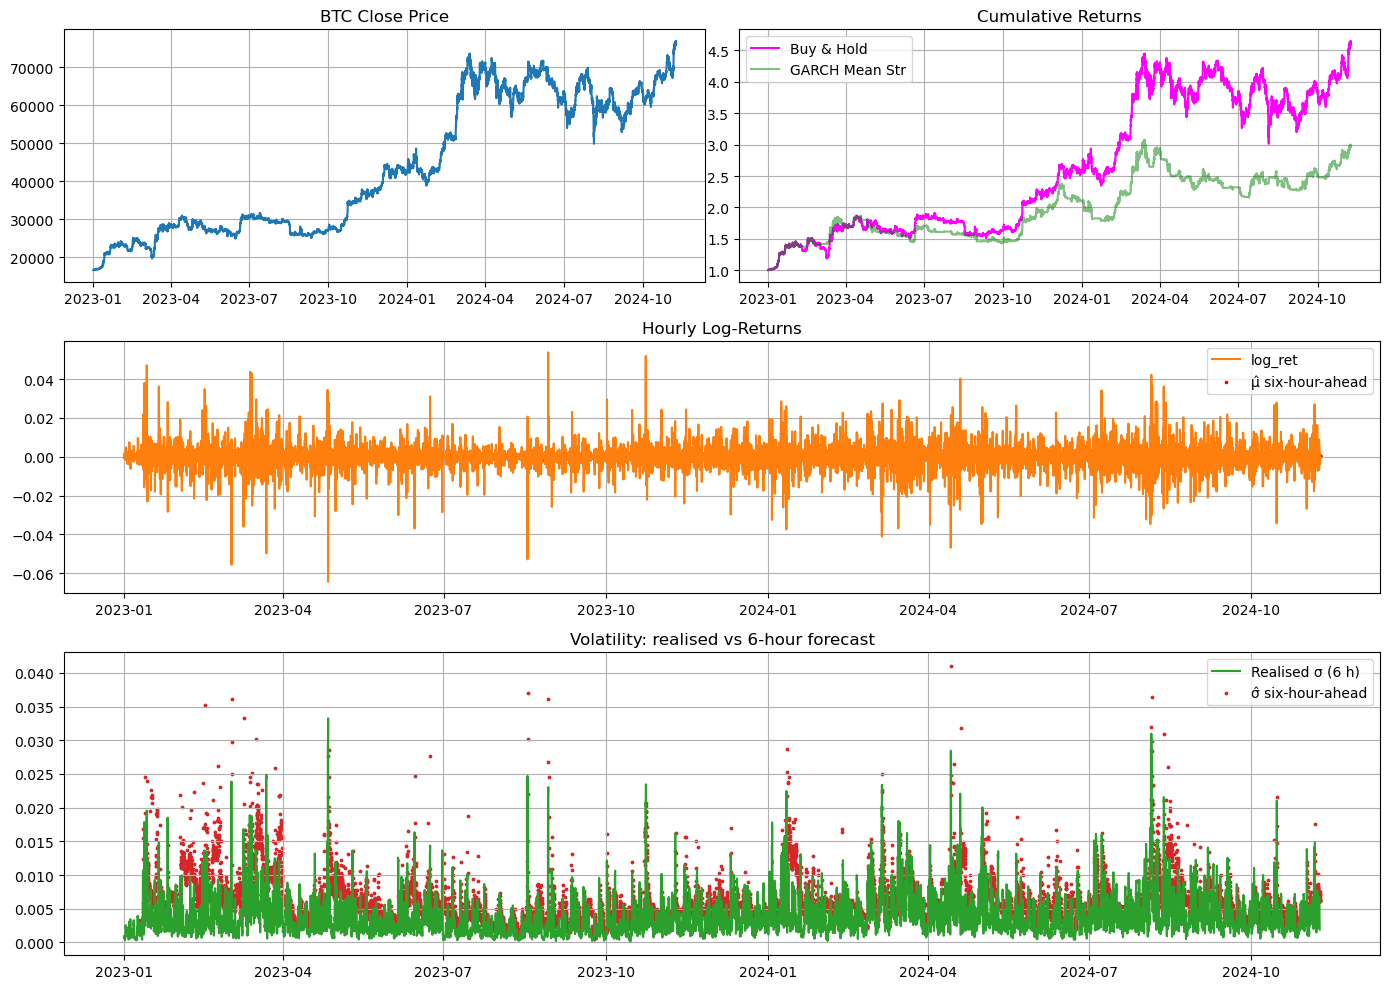

16272 | 2024-11-08 19:00:00-06:00 | Close 76,310.00 | log_ret -0.00157 | RV6h  0.00192 | μ̂(t+6h) 0.00035085059664437344 | σ̂(t+6h) 0.00625910558713609 | position 1
Exit flag detected — stopping.


In [126]:
# ---------------- containers for plotting ---------------------------
ts_x, close_y, logret_y = [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
decision_log = []
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

# --------------------------------------------------------------------
for n, data in enumerate(simulate_market(btc, delay=0.05), start=1):
    latest    = data.iloc[-1]
    tstamp    = latest.name

    prev_pos = position        # use yesterday’s stance for today’s P/L

    # ---------- RETURN ACCRUAL ----------
    cum_asset += latest.log_ret
    cum_strat += prev_pos * latest.log_ret

    creturns_y.append(np.exp(cum_asset))      # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))     # strategy equity curve

    # -------------- realised volatility -----------------------------

    realised  = data['log_ret'].rolling(6).std().iloc[-1]

    # ---------- append to plotting lists -----------------------------
    ts_x.append(tstamp);         close_y.append(latest.close)
    logret_y.append(latest.log_ret);   realvol_y.append(realised)

# ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = latest.log_ret,
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,        
        cum_asset      = cum_asset,      
        cum_strat      = cum_strat         
    ))

    #------------------ conditions to train models --------------------
    vol_6h = mu_6h = np.nan
    if len(data) >= 200:

        # ---------------- ARMA(2, 2) model -------------------------------
        ret_series = data['log_ret'].dropna().iloc[-200:].copy()
        ret_series.index = pd.date_range(start=ret_series.index[0], periods=len(ret_series), freq='H')

        arima_model = ARIMA(ret_series, order=(2,0,2)).fit()
        mu_forecast = arima_model.forecast(steps=6)
        mu_6h = mu_forecast[-1]                                           # μ̂

        # ---------------- GARCH(1, 1) model ------------------------------
        train = data['log_ret'].dropna().iloc[-200:] * 1000

        res   = arch_model(train, vol='GARCH', p=1, q=1,
                           mean='Zero', dist='t', rescale=False).fit(disp='off')

        #-------- if optimizacion success, model fit ------------------
        if res.optimization_result.success:
            fcast  = res.forecast(horizon=6)

            sigma_vec = np.sqrt(fcast.variance.iloc[-1].values) / 1000
            vol_6h   = sigma_vec[-1]                                      # σ̂    


   
    # ------------------ dynamic σ_cut, binary stance ------------------
    # ----------------------------------------------------------
    # Dynamic σ_cut: use the 7-day median of realised σ once we
    # have at least one week of data; otherwise fall back to 0.8 %
    # ----------------------------------------------------------
    n_obs = len(realvol_y)                # how many hourly σ values we have

    if n_obs >= 24 * 7:                    # 24 h × 7 d  = 168 observations
        vol_median = (
            pd.Series(realvol_y)           # convert list → Series
            .rolling(24 * 7)             # 7-day rolling window
            .median()
            .iloc[-1]                    # most-recent median
        )
    else:
        vol_median = np.nan               # not enough data yet

    sigma_cut = (1.2 * vol_median          # 20 % safety margin
                if np.isfinite(vol_median)
                else 0.008)               # fallback = 0.8 % per 6 h

    eps            = 0.0001              # tiny mean filter


    # default: keep yesterday’s stance
    new_pos = position

    if np.isfinite(mu_6h) and np.isfinite(vol_6h):

        if mu_6h > eps:
            new_pos = 1  # Go/stay long
            reason = f"LONG: Positive return forecast (μ̂={mu_6h:.5f})"
        elif mu_6h < -eps and vol_6h > sigma_cut:
            new_pos = 0  # Go flat
            reason = f"FLAT: Negative or insufficient return forecast (μ̂={mu_6h:.5f})"
    else:
        new_pos = position  # Retain last position if no forecast
        reason = "NO CHANGE: No valid return forecast"

    position = int(new_pos)                               # ensure 0 or 1

    decision_log.append({
        "timestamp": tstamp,
        "prev_position": prev_pos,
        "new_position": new_pos,
        "mu_6h": mu_6h,
        "vol_6h": vol_6h,
        "sigma_cut": sigma_cut,
        "reason": reason
    })

                    
    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if not np.isnan(pred_6h):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        fcst_x.append(future_ts);   fcst_y.append(vol_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_6h)

        results_log.append(dict(timestamp      = future_ts,
                                close          = np.nan,
                                log_ret        = np.nan,
                                realized_vol   = np.nan,
                                forecasted_vol = vol_6h,
                                forecasted_mu  = mu_6h,
                                position       = position,
                                cum_asset      = cum_asset,
                                cum_strat      = cum_strat))

    # ------------------------------ plot ------------------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="GARCH Mean Str", color="green", alpha=0.5)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.scatter(mean_fcst_x, mean_fcst_y, color="red",
                marker="x", s=3, label="μ̂ six-hour-ahead")
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.scatter(fcst_x, fcst_y, color="tab:red",
                marker="o", s=3, label="σ̂ six-hour-ahead")
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
        f"log_ret {latest.log_ret: .5f} | RV6h {realised: .5f} | "
        f"μ̂(t+6h) {mu_6h if np.isfinite(mu_6h) else 'nan'} | "
        f"σ̂(t+6h) {vol_6h if np.isfinite(vol_6h) else 'nan'} | "
        f"position {position}")

    # Auto-stop via file flag
    if os.path.exists("exit.flag"):
        print("Exit flag detected — stopping.")
        break

    # if n == 5000: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
df_final = (df_results
              .groupby(level=0)
              .agg(close          = ('close',          'first'),
                   log_ret        = ('log_ret',        'first'),
                   realized_vol   = ('realized_vol',   'first'),
                   forecasted_vol = ('forecasted_vol', 'last'),
                   forecasted_mu  = ('forecasted_mu',  'last'),
                   position       = ('position',       'last'),
                   cum_asset      = ('cum_asset',      'last'),
                   cum_strat      = ('cum_strat',      'last'))
              .sort_index())      # keep index in time order

df_decision_log = pd.DataFrame(decision_log)

##### 4.3.8.1 Debugging strategy

In [127]:
df_decision_log.to_csv("decision_log_arma22_16272.csv")
df_final.to_csv("df_final_arma22_16272.csv")

In [129]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_final.index,
    y=df_final['cum_asset'],
    mode='lines',
    name='Buy & Hold Strategy'
))

fig.add_trace(go.Scatter(
    x=df_final.index,
    y=df_final['cum_strat'],
    mode='lines',
    name='Active Strategy'
))

fig.update_layout(
    title='Cumulative Returns: Strategy vs Buy & Hold',
    xaxis_title='Timestamp',
    yaxis_title='Cumulative Log Return',
    legend=dict(x=0, y=1.1, orientation='h'),
    hovermode='x unified',
    template='seaborn'  # Optional: try 'plotly', 'ggplot2', 'seaborn'
)

fig.show()


In [130]:
start = "2023-04-14"
end = "2023-07-10"

In [139]:
df_final[start:end].head(10).to_clipboard(excel=True)

In [141]:
mask = (df_decision_log['timestamp'] >= start) & (df_decision_log['timestamp'] <= end)

df_decision_log[mask].head(10).to_clipboard(excel=True)

In [142]:
df_final

close   log_ret  realized_vol  forecasted_vol  \
timestamp                                                                     
2022-12-31 19:00:00-06:00  16551.47  0.001318           NaN             NaN   
2022-12-31 20:00:00-06:00  16548.19 -0.000198           NaN             NaN   
2022-12-31 21:00:00-06:00  16533.04 -0.000916           NaN             NaN   
2022-12-31 22:00:00-06:00  16521.85 -0.000677           NaN             NaN   
2022-12-31 23:00:00-06:00  16530.71  0.000536           NaN             NaN   
...                             ...       ...           ...             ...   
2024-11-08 21:00:00-06:00       NaN       NaN           NaN        0.006195   
2024-11-08 22:00:00-06:00       NaN       NaN           NaN        0.006367   
2024-11-08 23:00:00-06:00       NaN       NaN           NaN        0.006162   
2024-11-09 00:00:00-06:00       NaN       NaN           NaN        0.006092   
2024-11-09 01:00:00-06:00       NaN       NaN           NaN        0.006259   

                           forecasted_mu  position  cum_asset  cum_strat  
timestamp                                                                 
2022-12-31 19:00:00-06:00            NaN         1   0.001318   0.001318  
2022-12-31 20:00:00-06:00            NaN         1   0.001120   0.001120  
2022-12-31 21:00:00-06:00            NaN         1   0.000204   0.000204  
2022-12-31 22:00:00-06:00            NaN         1  -0.000473  -0.000473  
2022-12-31 23:00:00-06:00            NaN         1   0.000063   0.000063  
...                                  ...       ...        ...        ...  
2024-11-08 21:00:00-06:00       0.000313         1   1.531913   1.093086  
2024-11-08 22:00:00-06:00       0.000373         1   1.530421   1.091595  
2024-11-08 23:00:00-06:00       0.000401         1   1.532262   1.093435  
2024-11-09 00:00:00-06:00       0.000411         1   1.531218   1.092392  
2024-11-09 01:00:00-06:00       0.000351         1   1.529647   1.090821  

[16279 rows x 8 columns]

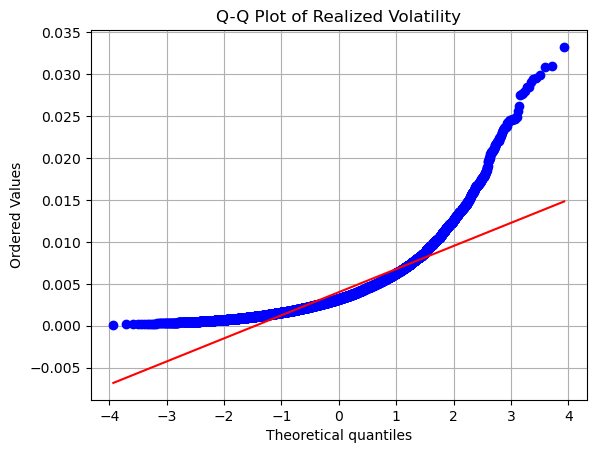

In [151]:
ad, p_value = normal_ad(df_final["realized_vol"].dropna())



stats.probplot(df_final["realized_vol"].dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Realized Volatility")
plt.grid(True)
plt.show()


#### 4.3.9 Rubusting

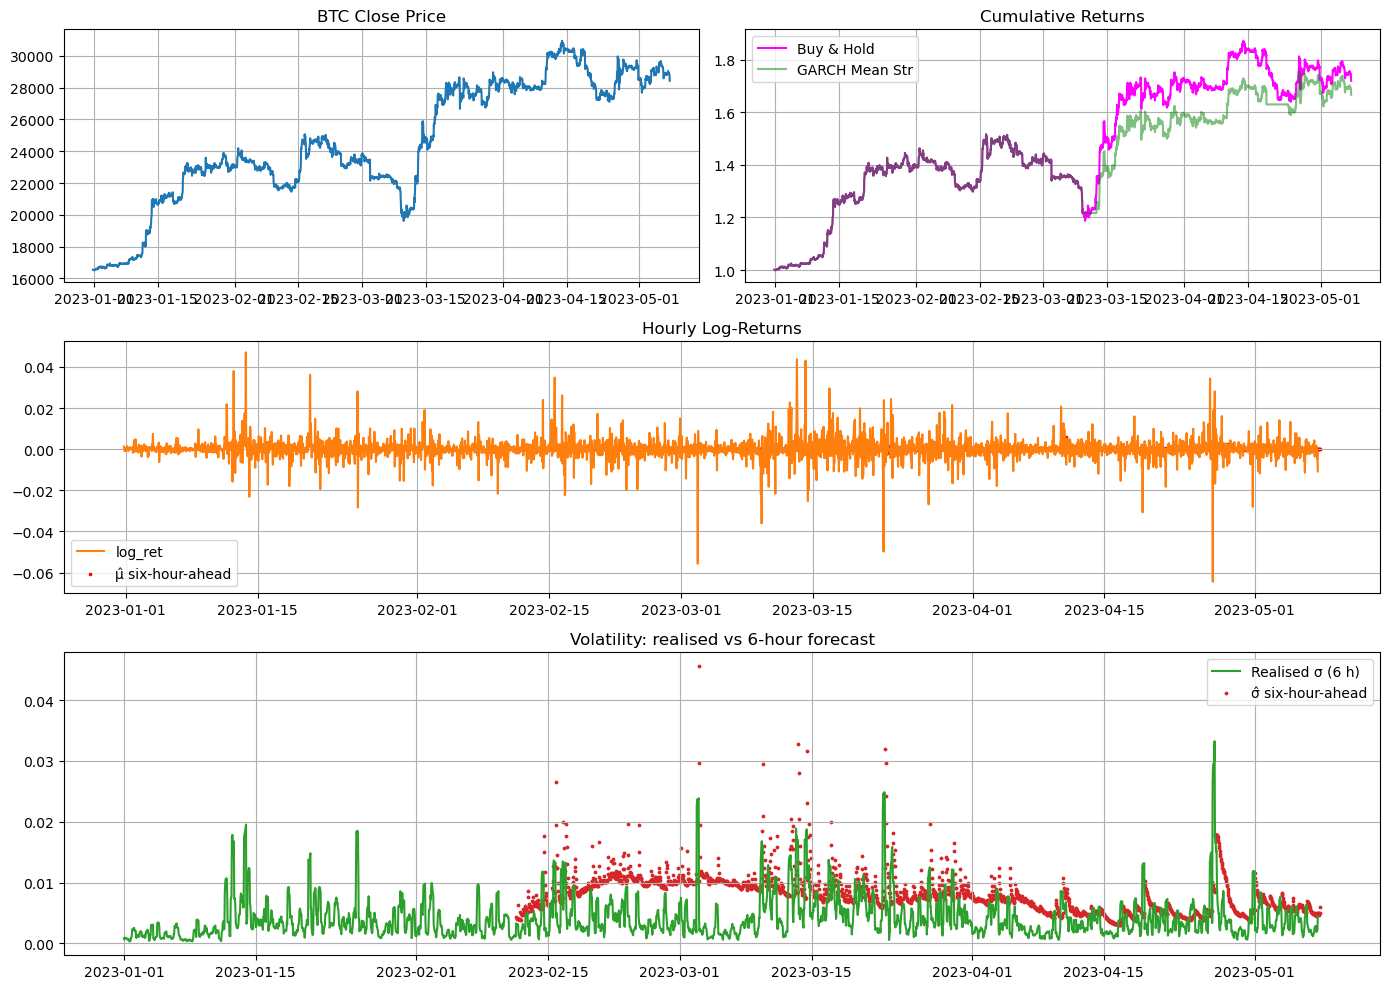

3046 | 2023-05-07 17:00:00-06:00 | Close 28,430.10 | log_ret -0.01081 | RV6h  0.00451 | μ̂(t+6h) -1.6316749146559434e-05 | σ̂(t+6h) 0.005976915271706116 | position 1
Exit flag detected — stopping.


In [155]:
# ---------------- containers for plotting ---------------------------
ts_x, close_y, logret_y = [], [], []
realvol_y               = []

fcst_x, fcst_y          = [], []       # points drawn 6 h in the future

cstrategy_y, creturns_y       = [], []     # <-- will be filled now

# ----- new containers for mean forecasts -----
mean_fcst_x, mean_fcst_y = [], []     # time-stamps & values

# ---------------- container for permanent storage -------------------
results_log = []              # one dict = one row in final DF
decision_log = []
position    = 1               # 1 = long ; 0 = flat
cum_asset   = 0.0             # cumulative *log* return of BTC
cum_strat   = 0.0             # cumulative *log* return of strategy

# --------------------------------------------------------------------
for n, data in enumerate(simulate_market(btc, delay=0.05), start=1):
    latest    = data.iloc[-1]
    tstamp    = latest.name

    prev_pos = position        # use yesterday’s stance for today’s P/L

    # ---------- RETURN ACCRUAL ----------
    cum_asset += latest.log_ret
    cum_strat += prev_pos * latest.log_ret

    creturns_y.append(np.exp(cum_asset))      # buy-&-hold equity curve
    cstrategy_y.append(np.exp(cum_strat))     # strategy equity curve

    # -------------- realised volatility -----------------------------

    realised  = data['log_ret'].rolling(6).std().iloc[-1]

    # ---------- append to plotting lists -----------------------------
    ts_x.append(tstamp);         close_y.append(latest.close)
    logret_y.append(latest.log_ret);   realvol_y.append(realised)

# ---------- baseline row ---------------------------------
    results_log.append(dict(
        timestamp      = tstamp,
        close          = latest.close,
        log_ret        = latest.log_ret,
        realized_vol   = realised,
        forecasted_vol = np.nan,
        forecasted_mu  = np.nan,
        position       = position,        
        cum_asset      = cum_asset,      
        cum_strat      = cum_strat         
    ))

    #------------------ conditions to train models --------------------
    vol_6h = mu_6h = np.nan
    momentum = data['log_ret'].rolling(24).sum().iloc[-1] # 1-day return

    if len(data) >= 1000:

        # ---------------- ARMA(2, 2) model -------------------------------
        ret_series = data['log_ret'].dropna().iloc[-1000:].copy()
        ret_series.index = pd.date_range(start=ret_series.index[0], periods=len(ret_series), freq='H')

        arima_model = ARIMA(ret_series, order=(2,0,2)).fit()
        mu_forecast = arima_model.forecast(steps=6)
        mu_6h = mu_forecast[-1]                                           # μ̂

        # ---------------- GARCH(1, 1) model ------------------------------
        train = data['log_ret'].dropna().iloc[-1000:] * 1000

        res   = arch_model(train, vol='GARCH', p=1, q=1,
                           mean='Zero', dist='t', rescale=False).fit(disp='off')

        #-------- if optimizacion success, model fit ------------------
        if res.optimization_result.success:
            fcast  = res.forecast(horizon=6)

            sigma_vec = np.sqrt(fcast.variance.iloc[-1].values) / 1000
            vol_6h   = sigma_vec[-1]                                      # σ̂    


   
    # ------------------ dynamic σ_cut, binary stance ------------------

    λ          = 0.94          # decay
    alpha      = 1 - λ
    target_exp = 0.008         # floor
    k          = 1.5
    min_obs    = 30            # safety

    rv = pd.Series(realvol_y).dropna()       # realised σ list → Series

    if len(rv) >= min_obs:
        stats      = rv.ewm(alpha=alpha, adjust=False)
        ewma_mean  = stats.mean().iloc[-1]
        ewma_sd    = np.sqrt(stats.var(bias=False).iloc[-1])
        sigma_cut  = max(target_exp, ewma_mean + k * ewma_sd)
    else:
        sigma_cut  = target_exp

    eps            = 0.0005              # tiny mean filter


    # default: keep yesterday’s stance
    new_pos = position

    if np.isfinite(mu_6h) and np.isfinite(vol_6h):

        if mu_6h > eps and momentum > 0:
            new_pos = 1  # Go/stay long
            reason = f"LONG: Positive return forecast (μ̂={mu_6h:.5f}) and momentum: {momentum:.5f}"
        elif mu_6h < -eps and vol_6h > sigma_cut:
            new_pos = 0  # Go flat
            reason = f"FLAT: Negative or insufficient return forecast (μ̂={mu_6h:.5f}), (sigma_cut={sigma_cut:.5f})"
    else:
        new_pos = position  # Retain last position if no forecast
        reason = "NO CHANGE: No valid return forecast"

    position = int(new_pos)                               # ensure 0 or 1

    decision_log.append({
        "timestamp": tstamp,
        "prev_position": prev_pos,
        "new_position": new_pos,
        "mu_6h": mu_6h,
        "vol_6h": vol_6h,
        "sigma_cut": sigma_cut,
        "reason": reason
    })

                    
    # ---------- if we have a forecast, plot & store it 6 h ahead ------
    if not np.isnan(vol_6h):
        future_ts   = tstamp + pd.Timedelta(hours=6)

        fcst_x.append(future_ts);   fcst_y.append(vol_6h)
        mean_fcst_x.append(future_ts); mean_fcst_y.append(mu_6h)

        results_log.append(dict(timestamp      = future_ts,
                                close          = np.nan,
                                log_ret        = np.nan,
                                realized_vol   = np.nan,
                                forecasted_vol = vol_6h,
                                forecasted_mu  = mu_6h,
                                position       = position,
                                cum_asset      = cum_asset,
                                cum_strat      = cum_strat))

    # ------------------------------ plot ------------------------------
    clear_output(wait=True)
    fig = plt.figure(figsize=(14, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])


    # 1) Price
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts_x, close_y, color="tab:blue")
    ax1.set_title("BTC Close Price"); ax1.grid(True)


    # 2) Cum-returns vs strategy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(ts_x, creturns_y,  label="Buy & Hold", color="magenta")
    ax2.plot(ts_x, cstrategy_y, label="GARCH Mean Str", color="green", alpha=0.5)
    ax2.set_title("Cumulative Returns"); ax2.legend(); ax2.grid(True)

    # 3) Log-returns + mean
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(ts_x, logret_y, color="tab:orange", label="log_ret")
    ax3.scatter(mean_fcst_x, mean_fcst_y, color="red",
                marker="x", s=3, label="μ̂ six-hour-ahead")
    ax3.set_title("Hourly Log-Returns"); ax3.legend(); ax3.grid(True)


    # 4) Volatility
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(ts_x, realvol_y, color="tab:green", label="Realised σ (6 h)")
    ax4.scatter(fcst_x, fcst_y, color="tab:red",
                marker="o", s=3, label="σ̂ six-hour-ahead")
    ax4.set_title("Volatility: realised vs 6-hour forecast")
    ax4.legend(); ax4.grid(True)

    plt.tight_layout(); plt.show()

    print(f"{n:3d} | {tstamp} | Close {latest.close:,.2f} | "
        f"log_ret {latest.log_ret: .5f} | RV6h {realised: .5f} | "
        f"μ̂(t+6h) {mu_6h if np.isfinite(mu_6h) else 'nan'} | "
        f"σ̂(t+6h) {vol_6h if np.isfinite(vol_6h) else 'nan'} | "
        f"position {position}")

    # Auto-stop via file flag
    if os.path.exists("exit.flag"):
        print("Exit flag detected — stopping.")
        break

    # if n == 5000: break

# ------------------------- FINAL DF -------------------------
# 1) Build DataFrame, set index, sort
df_results = (pd.DataFrame(results_log)
                .set_index("timestamp")
                .sort_index())          # ensure chronological order

# 2) Collapse to hourly granularity
df_results.index = df_results.index.floor("h")

# 3) Aggregate duplicates:
#    - take FIRST actual price/return/realised vol for the hour
#    - take LAST forecasts & cumulative P/L (they belong to the future row)
df_final = (df_results
              .groupby(level=0)
              .agg(close          = ('close',          'first'),
                   log_ret        = ('log_ret',        'first'),
                   realized_vol   = ('realized_vol',   'first'),
                   forecasted_vol = ('forecasted_vol', 'last'),
                   forecasted_mu  = ('forecasted_mu',  'last'),
                   position       = ('position',       'last'),
                   cum_asset      = ('cum_asset',      'last'),
                   cum_strat      = ('cum_strat',      'last'))
              .sort_index())      # keep index in time order

df_decision_log = pd.DataFrame(decision_log)